# **Introduction to Probabilistic Thinking and Programming**

<img src="https://www.pulsecarshalton.co.uk/wp-content/uploads/2016/08/jk-placeholder-image.jpg" width="60%" />

[Add prac relevant image. Suggestions welcome!]

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/Introduction_to_Probabilistic_Thinking_and_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** Elizaveta Semenova, Kira Düsterwald & James Allingham

**Reviewers:**

**Introduction:**

Thinking probabilistically and working with probability distributions can be very powerful tools for any machine learning practitioner. Unfortunately, they are tools that are often disregarded due to their *perceived* complexity. In this practical we hope to demistify these ideas by building intuition, provided practical tips, and introducing a very powerful framework for embracing the probabilistic approach – **probabilistic programming**. We'll both motivate why we need probabilistic programming and give a introduction for using it in practice.

This prac is aimed at all knowledge levels! No matter what your prior experience with probabilistic thinking and/or programming, we are sure that you will be able to take away some useful knowledge from this practical. However, this means that depending on your level, some of the content will not be aimed at you. Don't worry, this will be clearly marked at all points. We reccomend that you try and stick to our suggestions in order to get the most out of this prac in the given time, but if curiosity gets the better of you that's also great!

**Topics:**

Content: <font color='red'>`Bayesian Probability`</font>, <font color='purple'>`Probabilistic Programming`</font>

Level: <font color='blue'>`Beginner`</font>, <font color='orange'>`Intermediate`</font> & <font color='green'>`Advanced`</font>


**Aims/Learning Objectives:**

* [<font color='blue'>`Beginner`</font>] Understand what random variables and probability distributions are.
* [<font color='blue'>`Beginner`</font>] Be able to work with probability distributions using `numpyro`.
* [<font color='orange'>`Intermediate`</font>] Understand the difference between MLE, MAP, and Bayesian learning.
* [<font color='green'>`Advanced`</font>] Understanding the challenges involved in computing Bayes rule, and how probabilistic programming solved these.
* [<font color='green'>`Advanced`</font>] Be able to implement a simple probabilistic program with `numpyro`.

**Prerequisites:**

* Basic machine learning (e.g., simple supervised and unsupervised machine learning techniques).
* Basic calculus (e.g., computing an integral and taking derivatives to solve min/max optimisation problems).
* Python programming (with `jax` and `numpy`).

**Outline:**

[Points that link to each section. Auto-generate following the instructions [here](https://stackoverflow.com/questions/67458990/how-to-automatically-generate-a-table-of-contents-in-colab-notebook).]

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Important:** you will also need to go to "Tools" > "Settings" > "Miscellaneous" > check "Crab Mode".

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title [TODO] **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced" #@param ["beginner", "intermediate", "advanced"]

sections_to_follow=""

if experience == "beginner":
  sections_to_follow="Introduction -> 1.1 Subsection -> 2.1 Subsection -> Conclusion -> Feedback"
elif experience == "intermediate":
  sections_to_follow="Introduction -> 1.2 Subsection -> 2.2 Subsection -> Conclusion -> Feedback"
elif experience == "advanced":
  sections_to_follow="Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback"

print(f"Based on your experience, it is advised you follow these -- {sections_to_follow} sections. Note this is just a guideline.")

Based on your experience, it is advised you follow these -- Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback sections. Note this is just a guideline.


## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

!pip install numpyro

import jax
from jax import random
import jax.numpy as jnp
from jax import random

import numpyro
numpyro.enable_validation()
# ^ This allows numpyro to check e.g., if x is in the domain of a uniform dist.
# Since speed isn't a requirement for a tutorial, let's keep it on.
import numpyro.distributions as dist
import numpy as np

from scipy.stats import gaussian_kde
import scipy.stats as stats
import math
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# adapts colours for theme
from google.colab import output
is_dark = output.eval_js('document.documentElement.matches("[theme=dark]")')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
# @title Helper Functions. (Run Cell)

def Gaussian_conditional(mean, cov, x=None,y=None):
  assert not (x is None and y is None) and not (x is not None and y is not None)
  if x is not None:
    var = cov[1,1] -  cov[1,0] * cov[0,0] ** (-1) * cov[0,1]
    mu = mean[1] + cov[1,0] * cov[0,0] ** (-1) * (x - mean[0])
  else:
    var = cov[0,0] -  cov[0,1] * cov[1,1] ** (-1) * cov[1,0]
    mu = mean[0] + cov[0,1] * cov[1,1] ** (-1) * (y - mean[1])
  return mu, var**0.5

def plot_log_gaussian_ellipse(ax, mean, cov, color='b', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[1, 2, 4, 6]):

  eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
  theta = jnp.linspace(0, 2*jnp.pi, 1200);
  std_ellipsis = (jnp.sqrt(eigenvalues[None,:]) * eigenvectors) @ jnp.stack([jnp.sin(theta), jnp.cos(theta)])

  artists = []

  for level in std_levels:
    artists.append(ax.plot(mean[0] + level*std_ellipsis[0,:],
                           mean[1] + level*std_ellipsis[1,:], c=color,
                           alpha=alpha, lw=lw))

  artists.append(ax.scatter([mean[0]], [mean[1]], MAP_size, color=color,
                            label=label, alpha=alpha, marker='x'))

  return artists

In [ ]:
# adapt colours for theme
if(is_dark):
  prior_col = 'yellow'
  post_col = 'cyan'
  like_col = 'pink'
else:
  prior_col = 'purple'
  post_col = 'gray'
  like_col = 'teal'

In [ ]:
# Since we are using Jax, we will need a random key:
rng = random.PRNGKey(42)

# Part A: Probability distributions and random variables – <font color='blue'>`Beginner`</font>

*Note: unless marked otherwise, all subsections in this section are <font color='blue'>`Beginner`</font> friendly.* 🙂

In order to dive into the exciting world of probabilistic thinking and programming, we first need to build some important foundations. In particular, we will need understand what a probability distribution is, some simple but fundamental rules of probability, and how to interact with probabilities in code. Along with way, we will have some opportunities to explore some practical tips and tricks that will be very useful for our exploration of probabilistic world.

Probability distributions and random variables allow us to describe and do calculations involving random events, i.e., events whose outcomes are random. An example of such a random event would be flipping a coin or rolling a die. In the first case, the possible outcomes are *heads* or *tails*.

**Group task 1:** discuss with your neighbours, what are the possible outcomes when rolling a die?


A **random variable** $X$ allows us to assign numerical values to the possible outcomes of a random event. For example in the coin flipping example we could use a binary random varible with $X = 1$ if the coin is heads and $X = 0$ for tails.

**Group task 2:** discuss with your neighbours and write down a random variable to describe the die rolling event.

A **probability distribution** $p(X = x)$ describes the probability that $X$ takes each of its possible values $x$.

In order to make things more concrete, let's explore a few common probabilty distributions.

#### Answer to group task A1

Assuming that the die has 6 sides, the outcomes are ⚀, ⚁, ⚂, ⚃, ⚄, and ⚅.

#### Answer to group task A2


Note that there are many possible answers, here is one:

$$
X = \begin{cases}
1 \text{ if } ⚀ \\
2 \text{ if } ⚁ \\
3 \text{ if } ⚂ \\
4 \text{ if } ⚃ \\
5 \text{ if } ⚄ \\
6 \text{ if } ⚅ \\
\end{cases}
$$

### The Bernoulli distribution

A Bernoulli distribution is used to describe random events with two possible outcomes e.g., when we have a random variable that takes on one of two values $x \in \{0, 1\}$:
\begin{align}
p(X = 1) &= p \\
p(X = 0) &= 1 - p
\end{align}
where $0 \le p \le 1$. Here $p$ is a parameter which controls the probability of each outcome. For example, in the case of a *fair* coin toss, $p = 0.5$ so that both outcomes have a 50\% chance of occuring. As we will see shortly, most distributions have multiple parameters.

A probability distribution can be uniquely defined by its probability mass function (PMF), or probability desnity function (PDF) in the case of continuous distributions. For the Bernoulli distribution we write the PMF as
\begin{align}
p(X = x) = \text{Bernoulli}(X\mid p) &= \begin{cases}
p\, & \text{if } x = 1 \\
1 - p\, & \text{if } x = 0
\end{cases} \\
&= p^x(1-p)^{1-x}.
\end{align}

**Exercise:** convince yourself that the two definitions of the Bernoulli distribution shown above are equivalent.

Now let's construct a Bernoulli distribution in code, so that we can play around with it and get some intuition.

**Note:** In this practical we are going to use `numpyro` to construct our distributions. However there are several other `jax` packages that work similarly (e.g., `distrax`) as well as several options for `tensorflow` (e.g., `tensorflow_probability`) and `pytorch` (e.g., `torch.distribution`). Don't worry too much about the specifics of how `numpyro` works, e.g., the names of the distributions and their arguments, instead try to understand what the code is doing.

In [ ]:
p = jnp.array(0.5)
bernoulli = dist.Bernoulli(probs=p)

Now that we have constructed the distribution we can get a sample from it:

In [ ]:
sample = bernoulli.sample(key=rng)
print(sample)

1


And we can evaluate the probability of observing a sample.

**Note:** the distribution objects in `numpyro` (and indeed most other libraries for probability distributions) return *log*-probabilities, rather than raw probabilities. This means that we need to take the exponent if we want to know the probabilitiy.

In [ ]:
log_prob = bernoulli.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 1) = -0.6931471824645996
p(X = 1) = 0.5


As expected, we get a probability of 0.5.

We can also easily get multiple samples:

In [ ]:
n = 6 #@param {type:"slider", min:1, max:10, step:1}
samples = bernoulli.sample(key=rng, sample_shape=(n,))
print(samples)

[0 0 0 1 1 0]


What if we wanted to evaulate the probability of observing all of our samples?

The `bernoulli` object we created earlier treats each each sample individually, and returns the probabilities of observing each sample on its own:

In [ ]:
individual_sample_probs = jnp.exp(bernoulli.log_prob(samples))
print(individual_sample_probs)

[0.5 0.5 0.5 0.5 0.5 0.5]


But, we can use the one of the laws of probability to compute the probability of observing all of the samples together:
$$
p(X_1=x_1, X_2=x_2, \dots, X_N=x_n) = \prod_{n=1}^N p(X_n=x_n).
$$
This is called the *product rule of probability*, and it says that for *independent* random variables, the joint probability (i.e., the probability of observing them all together) is equal to the product of the individual probabilities.

Now, let's calculate the joint probability of our samples.

In [ ]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

0.015625


**Group task 3:** Discuss with your neighbour, why do you think that libraries usually return *log*-probabilities?

**Group task 4:** Play with the following slider, and make sure that you understand the role of the Bernoulli distribution's $p$ parameter.

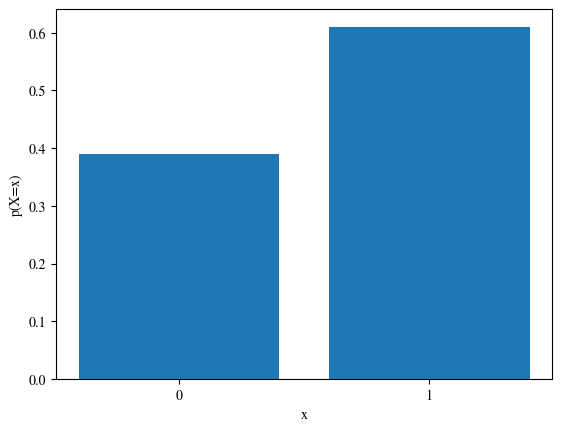

In [ ]:
#@title Bernoulli distribution interactive excercise { run: "auto" }

p_ = 0.61 #@param {type:"slider", min:0, max:1, step:0.01}

n_ = 1000
bernoulli_ = dist.Bernoulli(probs=p_)
samples_ = bernoulli_.sample(key=rng, sample_shape=(n_,))

num_ones = (samples_ == 1.).sum()
num_zeros = (samples_ == 0.).sum()

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.bar([0, 1], [num_zeros/n_, num_ones/n_])
ax.set_xticks([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()

#### Answer to group task A3


The answer, as is often the case, is numerical stability! When working with numbers between 0 and 1 (i.e., probabilities) it is easy to run into underflow.

For example, consider computing the probability of several independent events $A$, $B$, $C$, $\ldots$:
$$
p(A, B, C, \ldots) = p(A) \times p(B) \times p(C) \times \ldots,
$$
because we are multiplying numbers that are between 0 and 1, we know that the result will be smaller for each multiplication. As we perform more and more multiplications, it becomes more likely that the computation will underflow and erroneously produce a result of 0.

We can avoid this problem by instead working with log-probabilities. Continuing the above example we get
$$
\log p(A, B, C, \ldots) = \log p(A) + \log p(B) + \log p(C) + \ldots,
$$
where by the log laws, we have replaced all of the multiplications with additions, thereby avoiding any numerical issues.

## [Optional] a note on notation

In the text above we introduced a lot of new notation, so let's spend a little more time to make sure that everything is clear before moving on. If you are new to this topic, or have seen some of it before but are confused by the way we've written things, then give this section a read.

**$X$ vs $x$**

* $X$ representes a random variable, that is, a variable which could take on several different values, depending on the outcome of some random event.
* $x$ represents a particular value that $X$ could take. You can think of $x$ much like a python variable `x` which at any time has a single value.
*One way of deciding whether to write $X$ or $x$ is to as the question "Is the value of the variable known?", if the answer is yes then we write $x$, if the answer is no, then we write $X$.

**$p(X = x)$ vs $p(X)$ vs $p(x)$**

* $p(X)$ is a shorthand that means the same thing as $p(X = x)$, i.e., it represents the PDF of a random variable $X$.
* $p(x)$ has a slightly different meaning, it signifies that probability of the random variable $X$ taking the value $x$. Instead of representing the PDF, it represents the PDF evaluated at $x$. It is a probability value rather than a function.
* You might also see the notation $p_X(x)$, which has the same meaning as $p(x)$, but includes the random varialbe $X$ for clarity, as if we write $p_X(1)$ we can still see that the random varaible is $X$.


**$p$ vs $P$**

* Sometimes you may see notation that uses both $p$ and $P$. In this case $P$ and $p$ are being used to differentiate between distributions for *discrete* and *continuous* random variables, respectively.
* You may also see other notations such as $\text{Pr}$ or $\mathbb{P}$. These don't have any special meaning unless otherwise mentioned in the text where they appear.





## The categorical distribution

A categorical distribution is used to model random events with multiple *discrete* outcomes, such as the die rolling event from above. By discrete, we mean that there is a countable number of outcomes. We will tackle uncountable outcomes shortly.

As with the Bernoulli distribution, we can characterise the categorical distribution with its PMF:
\begin{align}
p(X = x) = \text{categorical}(X\mid\mathbf{p}) = \prod_{k=1}^K p_k^{[x=k]},
\end{align}
where $K$ is the number of outcomes, $\textbf{p} = [p_1, p_2, \dots, p_K]$, $p_k$ is the probability of the $k$th outcome, $\sum_k p_k = 1$, and $[x = k]$ is called an Iverson bracket which evaluates to 1 if $x = k$ and 0 otherwise.

**Exercise:** convince yourself that a categorical distribution with $K = 2$ is equivalent to a Bernoulli distribution.

Now, let's start playing with this distribution in code!

In [ ]:
ps = jnp.array([0.1, 0.2, 0.3, 0.4])
categorical = dist.Categorical(probs=ps)

As before we can take some samples:

In [ ]:
samples = categorical.sample(key=rng, sample_shape=(10,))
print(samples)

[3 2 1 3 3 1 2 1 3 3]


And compute the probability for each of the random events:

In [ ]:
print(f"p(X=0) = {jnp.exp(categorical.log_prob(0)):.1f}")
print(f"p(X=1) = {jnp.exp(categorical.log_prob(1)):.1f}")
print(f"p(X=2) = {jnp.exp(categorical.log_prob(2)):.1f}")
print(f"p(X=3) = {jnp.exp(categorical.log_prob(3)):.1f}")

p(X=0) = 0.1
p(X=1) = 0.2
p(X=2) = 0.3
p(X=3) = 0.4


**Group task 5:** Play with the following sliders, which control the paramters of the categorical distribution. Note that because $\sum_k p_k = 1$, we are using an alternative way to represent the categorical distribution. Instead of specifying the probabilities $p_k$, we specifiy logits $l_k$. Each $p_k$ is then computed as
$$
p_k = \frac{\exp(l_k)}{\sum_{k'}\exp(l_k)},
$$
i.e., using the softmax function.

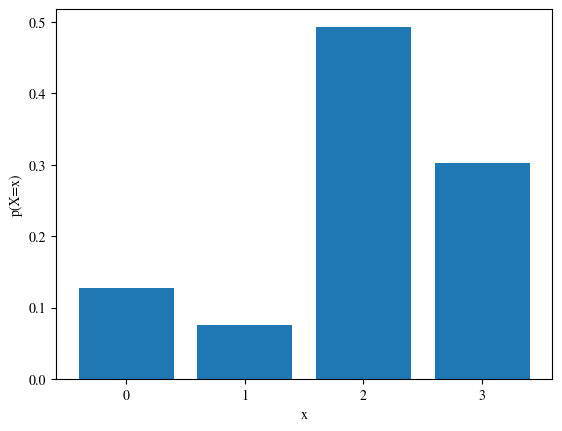

In [ ]:
#@title categorical distribution interactive excercise {run: "auto"}
l_0 = 0.7 #@param {type:"slider", max:4, step:0.1}
l_1 = 0.3 #@param {type:"slider", max:4, step:0.1}
l_2 = 2 #@param {type:"slider", max:4, step:0.1}
l_3 = 1.6 #@param {type:"slider", max:4, step:0.1}

logits_ = jnp.array([l_0, l_1, l_2, l_3], dtype=jnp.float32)
categorical_ = dist.Categorical(logits=logits_)
samples_ = categorical_.sample(key=rng, sample_shape=(1000,))

values =[0, 1, 2, 3]
hist, _ = jnp.histogram(
    samples_, bins=jnp.array(values + [4]), density=True
)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.bar(values, hist)
ax.set_xticks(values)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()

## The normal distribution

The normal, also known as Gaussian, distribution is one of the most common distributions for modelling *continuous* random variables, i.e., corresponding to events with an uncountable number of outcomes. It's probability density function is
$$
p(X = x) = \mathcal{N}(x\mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mu - x)^2}{2\sigma^2}\right),
$$
where $\mu$ and $\sigma$ are the *mean* and *standard deviation* (also called the location, and scale or square-root of the *variance* $\sigma^2$, respectively).

Once again, the best way to get a sense for this distribution is to play with some code!

**Group task 6:** play with the following sliders, and discuss with your neighbours – how do the mean and standard deviation affect the samples?

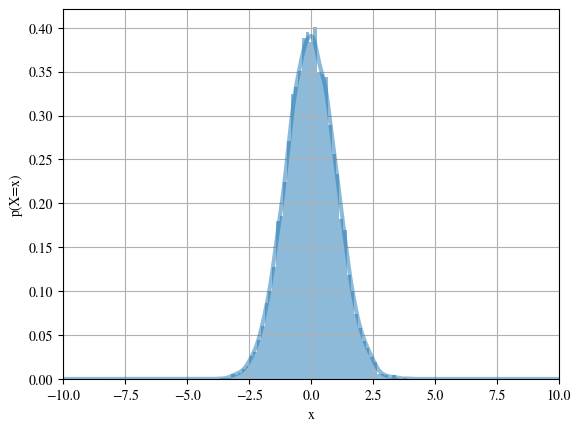

In [ ]:
#@title normal distribution interactive excercise {run: "auto"}
μ_ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ_ = 1 #@param {type:"slider", max:4, step:0.1}

normal = dist.Normal(loc=μ_, scale=σ_)
samples_ = normal.sample(key=rng, sample_shape=(10000,))

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(samples_, bins=50, density=True, alpha=0.5)
x = jnp.linspace(-10, 10, 3000)
kde = gaussian_kde(samples_)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.set_xlim(-10, 10)
ax.grid(0.3)
plt.show()

In [ ]:
#@title Implementing the normal PDF from scratch!
#@markdown **code task 1:** Let's implement the PDF for the normal distribution from scratch, just using functions from `jax`.
#@markdown *Hint:* You may want to use `jnp.pi`, `jnp.sqrt`, and `jnp.exp`.

def normal_pdf(loc, scale, x):
    p_x =  # TODO: your code goes here!

    return p_x

SyntaxError: ignored

In [ ]:
# @title Run me to test your code

def test_normal_pdf(pdf_fn):
  assert pdf_fn(0, 1, 0) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(0)), "Normal(X=0|0, 1) is incorrect."
  assert pdf_fn(0, 2, 0) == jnp.exp(dist.Normal(loc=0, scale=2).log_prob(0)), "Normal(X=0|0, 2) is incorrect."
  assert pdf_fn(0, 1, 1) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(1)), "Normal(X=0|1, 1) is incorrect."
  assert pdf_fn(2, 3, 1) == jnp.exp(dist.Normal(loc=2, scale=3).log_prob(1)), "Normal(X=1|2, 3) is incorrect."
  print("Nice! Your answer looks correct.")

test_normal_pdf(normal_pdf)

NameError: ignored

In [ ]:
# @title Answer to code task 1 (Try not to peek until you've given it a good try!')

def normal_pdf(loc, scale, x):
    p_x = 1 / jnp.sqrt(2 * jnp.pi * scale**2)
    p_x *= jnp.exp(-((loc - x)**2) / (2 * scale**2))

    return p_x

test_normal_pdf(normal_pdf)

Nice! Your answer looks correct.


#### Answer to group task A6



The mean controls where the center of the distribution is located. In other words, it controls where the most likely *location* to sample a values is.

The standard deviation controls how wide the distribution is. In other words, it controls how likely we are to draw samples farther away from the mean.

### Expected Values

The expected value of a random variable is the value that we expect to get on average when we sample a large number of different outcomes from the random event.

For example, if we consider our example of flipping a coin from above, where $X = 1$ if the coin lands on heads and $X = 0$ if the coin lands on tails, then intuitively the expected value is $0.5$.

More precisely, we can write the expected value as
$$
\mathbb{E}[X] = \sum_x x \cdot p(X=x),
$$
for a discrete random variable $X$. For a continuous random varaible, the sum would be replaced with an integral. From this definition, we can think of the expected value as a weighted average of all of the values of $X$, where the weighting for each value is the probability of observing it.

**Group task 7:** Working with your neighbour, compute the expected value for the standard six-sided die rolling event from above.

#### Answer to group task A7

Assuming that we use the following random variable to represent our die throw
$$
X = \begin{cases}
1 \text{ if } ⚀ \\
2 \text{ if } ⚁ \\
3 \text{ if } ⚂ \\
4 \text{ if } ⚃ \\
5 \text{ if } ⚄ \\
6 \text{ if } ⚅ \\
\end{cases}
$$
the expected value is
$$
\mathbb{E}[X] = \frac{1}{6} \cdot 1 + \frac{1}{6} \cdot 2 + \frac{1}{6} \cdot 3 + \frac{1}{6} \cdot 4 + \frac{1}{6} \cdot 5 + \frac{1}{6} \cdot 6 = 3.5.
$$

#### Monte-Carlo estimation

Instead of computing an expected value exactly, we can estimate it using a *Monte-Carlo* approximation.  We can describe this procedure using the following mathematical notation:
$$
\mathbb{E}[X] \approx \frac{1}{N} \sum_{n=1}^{N} x_n\,, \quad x_n \sim p(X).
$$
That is, we sample $N$ values $x_n$ from $p(X)$ and then take the average. Because the values appear proportionally to their probabilities, for large values of $N$, this approximation will become accurate.

We can also implement this in code! Let's calculate the expected value of the normal distribution $\mathcal{N}(x \mid \mu, \sigma)$.

**Group task 8:** Working with your neighbours, play with the following sliders, and try to answer these questions:
1. Start with a large value for $N$ and a small value for $\sigma$, what number does the expected value approximate? *Hint:* change the value of $\mu$ and see what happens to the expected value.
2. Now, start decreasing $N$ and/or increasing $\sigma$. What happens to the expected value?
3. What notation in the equation above do lines 7 and 9 in the code bellow correspond to?

In [ ]:
#@title Expected value interactive excercise {run: "auto"}
N = 100 #@param {type:"slider", min:1, max:400, step:1}
μ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ = 1 #@param {type:"slider", min: 0.1, max:4, step:0.1}

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(key=rng, sample_shape=(N,))

expected_value = jnp.sum(samples) / N

print(f'E[X] = {expected_value:.5f}')

E[X] = 0.00990


##### Answer to group task A8


1. The expected value for a random variable with a normal distribution is the mean parameter $\mu$. For this reason the term *mean* is often used synonimously with *expected value*.
2. As we decrease $N$ and/or increase $\sigma$, the Monte Carlo approximation becomes less accurate. **Fun fact**, for a standard Monte Carlo approximator such as this, the approximation error decreases at a rate of $\sqrt{N}$. In other words, if we multiply $N$ by 4, the error in the approximation should be divided by 2.

#### Functions of random variables

We can also calculate expected values of functions of random variables. For example, the variance of a random variable can be caculated using the following expected value
$$
\mathbb{V}[X] = \mathbb{E}[(X - \mu)^2],
$$
where $\mu = \mathbb{E}[X]$ is the mean, as described above.

In [ ]:
#@title Estimating the variance - <font color='orange'>`Intermediate`</font>
#@markdown **[Optional] code task 2:** Let's implement a Monte Carlo estimator for the variance.
#@markdown You can tell if your answer is correct if the estimated variance is close to $\sigma^2$ for large $N$.

N = 100 #@param {type:"slider", min:1, max:400, step:1}
μ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ = 1 #@param {type:"slider", min: 0.1, max:4, step:0.1}

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(
    key=rng, sample_shape=(N,)
)

# TODO: your code goes here!

print(f'V[X] = {var:.5f}')


NameError: ignored

In [ ]:
# @title Answer to code task A2 (Try not to peek until you've given it a good try!')

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(
    key=rng, sample_shape=(N,)
)

mean = jnp.mean(samples)
var = jnp.mean((samples - mean)**2)

print(f'V[X] = {var:.5f}')

V[X] = 1.03964


#### [Optional] a note on notation: expectations

**$E$ vs $\mathrm{E}$ vs $\mathbb{E}$**

* You may also have seen a variety of notations for expected values ($E$, $\mathrm{E}$, $\mathbb{E}$) and variances ($V$, $\mathrm{V}$, $\mathbb{V}$, $\text{Var}$). Don't worry, all of these share the exact same meaning.

### [Optional] Reparameterisation - <font color='orange'>`Intermediate`</font>

Just for fun, let's explore an interesting (and useful!) property of the normal distribution.

Let's say we have samples $x_n$ from a $\mathcal{N}(x|0, 1)$ distribution, but what we really want is samples $y_n$ from $\mathcal{N}(y|\mu, \sigma)$. It turns out, that we can easily convert from $x_n$ to $y_n$, or vice-versa. To be specific, we can convert between the random variable $X$ to the random variable $Y$, as follows
$$
Y = \sigma X + \mu
$$
or
$$
X = Y/\sigma - \mu/\sigma.
$$

In fact, this property is several other probability distributions called the location-scale family. All of these distribuions have the similarity that they are parameterised by a location parameter $\mu$ and a scale paramter $\sigma$! Converting from one distribution to another like this is called *reparameterisation*.

As usual, let's convince ourselves that this is true with some code 😎

In [ ]:
normal_x = dist.Normal(loc=0, scale=1)
samples_x = normal_x.sample(key=rng, sample_shape=(5,))

μ = 1
σ = 2
normal_y = dist.Normal(loc=μ, scale=σ)
samples_y = normal_y.sample(key=rng, sample_shape=(5,))
# Note that we are using the same random key as above.

print(f"xs =\t\t{samples_x}")
print(f"ys =\t\t{samples_y}")
print(f"xs*σ + μ =\t{samples_x * σ + μ}")

xs =		[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]
ys =		[ 2.2245305   3.2451766  -0.7088268  -0.62546504 -0.78081   ]
xs*σ + μ =	[ 2.2245305   3.2451766  -0.7088268  -0.62546504 -0.78081   ]


#### [Optional] Extra reading – the reparameterisation trick - <font color='green'>`Advanced`</font>

When using gradient descent to learn the parameters of the distribution probability distribution given samples from that distribution, we run into a problem. It is not possible to back-propagate through a random operation like sampling. However, if we distribution we are trying to learn is reparameterisable (e.g., it is a from the location-scale family), then we can get around this issue. As an example, instead of doing
$$
z_i \sim \mathcal{N}(z\mid \mu, \sigma),
$$
we do
\begin{align}
x_i &\sim \mathcal{N}(x\mid 0, 1), \\
z_i &= x_i * \sigma + \mu.
\end{align}
As illustrated in the diagram below, this allows us to do back-propagation as required.

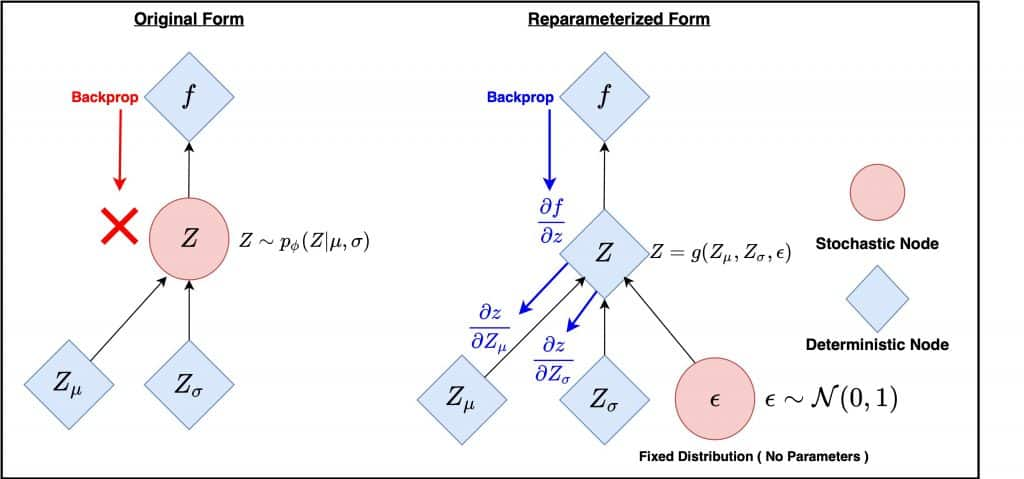

## The *multivariate* normal distribution

*Note: some of the mathematics (involving matrix algebra) in this section is slightly more complicated and may be closer to an <font color='orange'>`Intermediate`</font> level. If you are struggling with the matrices don't worry! We also present the special two-dimmensional case, which doesn't require any matrices. The important take-aways here are not the mathematics, but rather the concepts and intuitions which are still 100% certified <font color='blue'>`Beginner`</font> friendly.* 🙌

The multivariate normal distribution is a generalization of the normal distribution to consider multiple random variables that have a *joint* distribution. In other words, it lets us model variables that are not independent – if we know the value of one variable, that tells us something about the other variables! The more one variable tells us about another, the larger the *covariance* or *correlation* between the two. Enough text, let's take a look at the equations, which will hopefully give some further insight. First let's look at the general PDF for an $D$-dimmensional random variable $\mathbf{X}$:
$$
p(\mathbf{X} = \mathbf{x}) = \mathcal{N}(\mathbf{x}\mid \boldsymbol{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^D|\Sigma|}}\exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^\intercal\Sigma^{-1}(\mathbf{x} - \boldsymbol{\mu})\right),
$$
where $\mathbf{x}$ and $\boldsymbol{\mu}$ are now vectors of numbers rather than single numbers, $\Sigma$ is a *covariance matrix* that replaces $\sigma$ from our univariate definition above, and $|\Sigma|$ is its determinant. The covariance matrix looks like this:
$$
\Sigma = \left[\matrix{
    \sigma_1^2 & \rho_{12} \sigma_1 \sigma_2 & \cdots &  \rho_{1D} \sigma_1 \sigma_D  \\
    \rho_{21} \sigma_2\sigma_1 & \sigma_2^2 & \cdots &  \rho_{2D} \sigma_2 \sigma_D \\
    \vdots & \vdots & \ddots & \vdots \\
    \rho_{D1} \sigma_D \sigma_1 & \rho_{D2} \sigma_D \sigma_2 & \cdots & \sigma_D^2}\right],
$$
where $\sigma_i^2$ is the variance for the $i$th dimmension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$th and $j$th dimmensions.

**[Optional] group task:** If you and your neighbours are very comfortable with matrix algebra, try and convince yourselves that the equation above is equivalent to the univariate case when $D = 1$.

Now let's look at how the equation above simplifies in the two-dimensional case!
$$
p(X_1 = x_1, X_2 = x_2) = \mathcal{N}\left(\left[\matrix{x_1 \\ x_2}\right]\middle| \left[\matrix{\mu_1 \\ \mu_2}\right], \left[\matrix{\sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2}\right]\right) \\
= \frac{1}{2\pi\sigma_1\sigma_2\sqrt{1 - \rho^2}}\exp\left(-\frac{1}{2(1 - \rho^2)}\left[\left(\frac{x_1 - \mu_1}{\sigma_1}\right)^2 -2\rho\left(\frac{x_1 - \mu_1}{\sigma_1}\right)\left(\frac{x_2 - \mu_2}{\sigma_2}\right)  + \left(\frac{x_2 - \mu_2}{\sigma_2}\right)^2 \right] \right)
$$

**Group task 9:** Let's try understand what this equation means. Discuss the following questions with your neighbours. If the answers don't seem obvious to you, don't worry! As usual, we have some code to play with to help our understanding, so feel free to use any combination of mathematics and playing with sliders to help you understand. If playing with the sliders still doesn't help, don't worry, the next section will also make things more clear.
1. If $\rho = 0$, how does this two-dimensional case relate to the one-dimensional case above?
2. Now, think about what happens as $\rho$ becomes larger? What if it becomes negative?





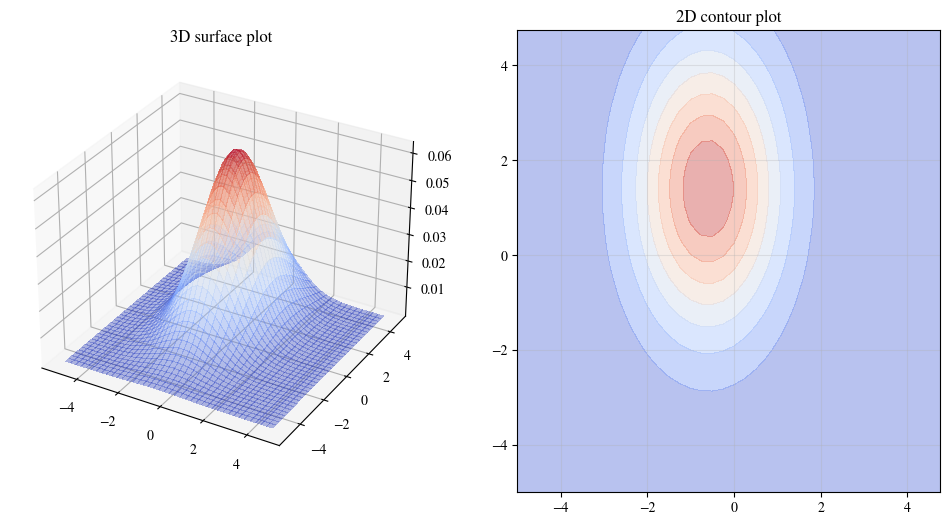

In [ ]:
#@title Multivariate normal interactive excercise 1 {run: "auto"}

#@markdown Both plots below show a 2D normal distribution. Each plot is useful for visualizing the distribution in different ways.

#@markdown The plot on the left helps us visualise the probability values for each $(x_1, x_2)$ pair.

#@markdown The plot on the right helps us visualise the shape of the distribution from above. Note that the colors represent the same probabilities as the left hand plot. Each ring shows pairs of equal probability.

from matplotlib import gridspec
from scipy.stats import norm

μ1 = -0.6 #@param {type:"slider", min:-5, max:5, step:0.1}
σ1 = 1.2 #@param {type:"slider", min: 0.1, max:4, step:0.1}
μ2 = 1.4 #@param {type:"slider", min:-5, max:5, step:0.1}
σ2 = 2.1 #@param {type:"slider", min: 0.1, max:4, step:0.1}
ρ = 0 #@param {type:"slider", min: -1, max:1, step:0.1}

μ = jnp.array([μ1, μ2])
Σ = jnp.array([[σ1**2, ρ*σ1*σ2],[ρ*σ2*σ1, σ2**2]])

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')

X1 = jnp.arange(-5, 5, 0.25)
X2 = jnp.arange(-5, 5, 0.25)
X1, X2 = jnp.meshgrid(X1, X2)
Xs = jnp.concatenate(
    [X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1
)
Z = jax.vmap(
    lambda x: jnp.exp(dist.MultivariateNormal(μ, Σ).log_prob(x))
)(Xs).reshape(X1.shape)

from matplotlib import cm
ax1.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                linewidth=0, alpha=0.4, antialiased=False)
ax1.set_title('3D surface plot')


ax2 = fig.add_subplot(122)
ax2.contourf(X1, X2, Z, cmap=cm.coolwarm,
            alpha=0.4, antialiased=False)
ax2.set_title('2D contour plot')


ax2.grid(alpha=0.3)
plt.show()

##### Answer to group task A9

1. If $\rho = 0$, the 2-dimensional case is the same as having two 1-dimensional gaussians. In this case, we see that the value of $X_1$ doesn't impact the value of $X_2$, and vice-versa.
2. As $\rho$ becomes larger, we see that the values of $X_1$ and $X_2$ do have some relation. Specifically, we see that for a large value of $X_1$ we expect to see a large value of $X_2$ (and vice-versa). If $\rho$ is negative, we still see that $X_1$ and $X_2$ affect each other, except now for large values of $X_1$, we get large *negative* values of $X_2$.

### The sum rule and the product rule revisited! [TODO - now integrated, needs colour!]

Now that we've introduced a multivariate distribution, we can use it to explore two important concepts when working with probability distributions – marginal and conditional distributions. This will naturally lead to two important rules of probablility that we'll need later in the practical (and life) – the sum and product rules.

Remember that formally, **joint probabilities** tell us the the probability of two or more events or random variables occuring. For two variables, we write $P(A=a,B=b)$. This isn't new - you just saw joint probabilities in action for the multivariate normal distribution! 🤔


#### Marginal distributions and the sum rule




Let's consider $p(X_1, X_2)$ a *joint* distribution over two random variables $X_1$ and $X_2$. Now, what if we only cared about one of the random variables e.g., $X_1$? We can use the *sum* rule to *marginalise* away $X_2$ from the joint distribution to give us the *marginal* distribution $p(X_1)$. Concretely, for a discrete $X_2$, the sum rule can be written as
$$
p(X_1 = x_1) = \sum_{x_2} p(X_1 = x_1, X_2 = x_2).
$$
Similarly, for a continuous $X_2$ we'd have
$$
p(X_1 = x_1) = \int p(X_1 = x_1, X_2 = x_2)\, \mathrm{d}x_2.
$$
This rule tells us that if we want a marginal distribution, we just need to enumerate all of the values of the variables that we don't want and sum the resulting distributions.

What if we have three (or more) random variables? Nothing special, which ever variables we don't want to keep in our marginal distribution, we sum over, for example
$$
p(X_1 = x_1, X_3 = x_3) = \sum_{x_2} \sum_{x_4} p(X_1 = x_1, X_2 = x_2, X_3 = x_3, X_4 = x_4).
$$

For a multivariate normal distribution, the sum rule has a very simple and clear form, which will hopefully make things more clear. Specifically, if
$$p(X_1, X_2) = \mathcal{N}\left(\left[\matrix{x_1 \\ x_2}\right]\middle| \left[\matrix{\mu_1 \\ \mu_2}\right], \left[\matrix{\sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2}\right]\right),$$
as defined above, then
$$
p(X_1) = \mathcal{N}\left(x_1 \mid \mu_1, \sigma_1\right).
$$
In other words, we simply 'drop' the variables that we don't care about, and get another normal distribution with only the ones that we do care about!

*Note:* some keen-eyed readers may have noticed something slightly strange... in the joint distribution formula all of the $σ$s on the diagonal are squared, where as in the marginal formal we just write $\sigma$ without the square. That is simply a convention, you can also write $\mathcal{N}\left(x_1 \mid \mu_1, \sigma_1^2\right)$, the meaning is the same.


Another way of expressing marginals, is that when we sum or integrate over all of the possibilities for one variable in a joint probability, we can get the probability distribution of the other! You can intuit the name by thinking of integrating or summing towards the $A$ or $B$ variable axis.

**Group task 10**: Discuss what marginalisation looks like on a Venn diagram?

##### Answer to group task A10

Marginal distributions are just the complete circles for each event, ignoring overlaps - here $P(A)$ and $P(B)$!

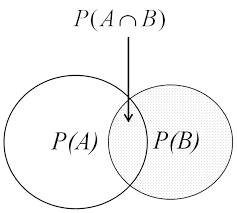

#### Conditional distributions and the product rule

As we mentioned above, we use *joint* distributions when one random variable tells us something about another random variable. But how do we actually use that information? For example, if $X_2 = 2$, how does that change the distribution over $X_1$? That is exactly what *conditional* distributions tell us. To be concrete the *conditional* distribution of $X_1$ given $X_2$ can be calculated as
$$
p(X_1 = x_1|X_2 = x_2) = \frac{p(X_1 = x_1, X_2 = x_2)}{p(X_2 = x_2)},
$$
in other words, it is the ratio of the *joint* distribution and the *marginal* distribution of the conditioning variable. Rearanging the above formula, we can now write down a formula for a *join* distribution in the case where the variables *are not* independant
$$
p(X_1 = x_1, X_2 = x_2) = p(X_1 = x_1|X_2 = x_2)p(X_2 = x_2).
$$
What $X_1$ and $X_2$ *are* independant? Then
$$
p(X_1 = x_1|X_2 = x_2) = p(X_1 = x_1),
$$
and the we can write the joint as
$$
p(X_1 = x_1, X_2 = x_2) = p(X_1 = x_1)p(X_2 = x_2),
$$
which recovers the formula we used in group task 3!

As above, for more than two variables, things are still simple
$$
p(X_1 = x_1, X_3 = x_3|X_2 = x_2, X_4 = x_4) = \frac{p(X_1 = x_1, X_2 = x_2, X_3 = x_3, X_4 = x_4)}{p(X_2 = x_2, X_4 = x_4)}
$$
or equivalently
$$
p(X_1 = x_1, X_2 = x_2, X_3 = x_3, X_4 = x_4) = p(X_1 = x_1, X_3 = x_3|X_2 = x_2, X_4 = x_4)p(X_2 = x_2, X_4 = x_4).
$$

And also like above, for the 2-dimmensional normal we get some simple equations which can help us understand what is going on when we work with conditional distributions.
$$
p(X_1=x_1|X_2=x_2) = \mathcal{N}\left(x_1\mid \mu_1 + \frac{\sigma_1}{\sigma_2}\rho(x_2 - \mu_2), (1 - \rho^2)\sigma_1^2\right).
$$

##### Relating the joint, marginal and conditional probability

These quantities are related via: $P(A,B) = P(A \vert B) P(B) = P(B \vert A) P(A)$.

**Group task 11:** Is it possible to show how a conditional probability $P(A \vert B)$ would look on a Venn diagram? What about the joint?

**Group task 12:** Can you see using your Venn diagram that the above statement about joint probabilities is true? What is $P(A\vert B)$ when $A$ and $B$ are independent events (i.e., no overlap on a Venn diagram)?

###### Answer to group task A11 and A12

We can show the joint, but the conditional also takes into account what happened to B - it compares the bit of the chart where both events happened to the bit where B happened.

Conditional probability of A given B:

$$P(A \vert B)=\frac{P(A \cap B)}{P(B)}.$$

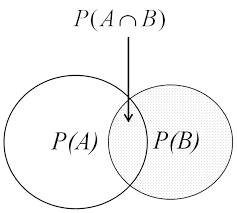


$P(A \vert B)$ - probability of event A given B has occurred<br>
$P(A \cap B)$ - probability that event A and B occurred (the joint, $P(A,B)$)

##### [Optional] a note on notation: conditional distributions

**What is the '$\mid$' in $p(X\mid a, b, c)$?**

* The bar we often see in the middle of probability distribution notation is used to separate the random variables of the distribution from the variables that the random variables are conditioned on.
* In other words, we have a function with two different kinds of inputs. The inputs on the right of $|$ are conditioning variables. The inputs on the left of $|$ are the values of the random variables under the probability distribution. The output of the function is the probability of the values of these random variables.
* We read $p(A \mid B, C)$ as 'the probability of A *given* B and C'.

##### Interactive exercise: Understanding the product and sum rule in 2 dimensions

**Group task 13:** Let's try to understand the equations for the sum and product rules by considering the 2-dimensional normal setting. Discuss the following questions with your neighbours. If the answers don't seem obvious to you, don't worry! As usual, we have some code to play with to help our understanding, so feel free to use any combination of mathematics and playing with sliders to help you understand.
1. If $\rho = 0$, what happens to the conditional distributions?
2. If $\rho \rightarrow 1$, what happens to the conditional distributions? (*Hint:* with a large $\rho$, try setting the standard deviations to 1 and then set mean values to 0 and then slowly increasing or decreasing them).
3. How do the standard deviations (and their ratio) impact the conditional distributions (for any value of $\rho$)?
4. How does the value of $\rho$ impact the marginal distributions?

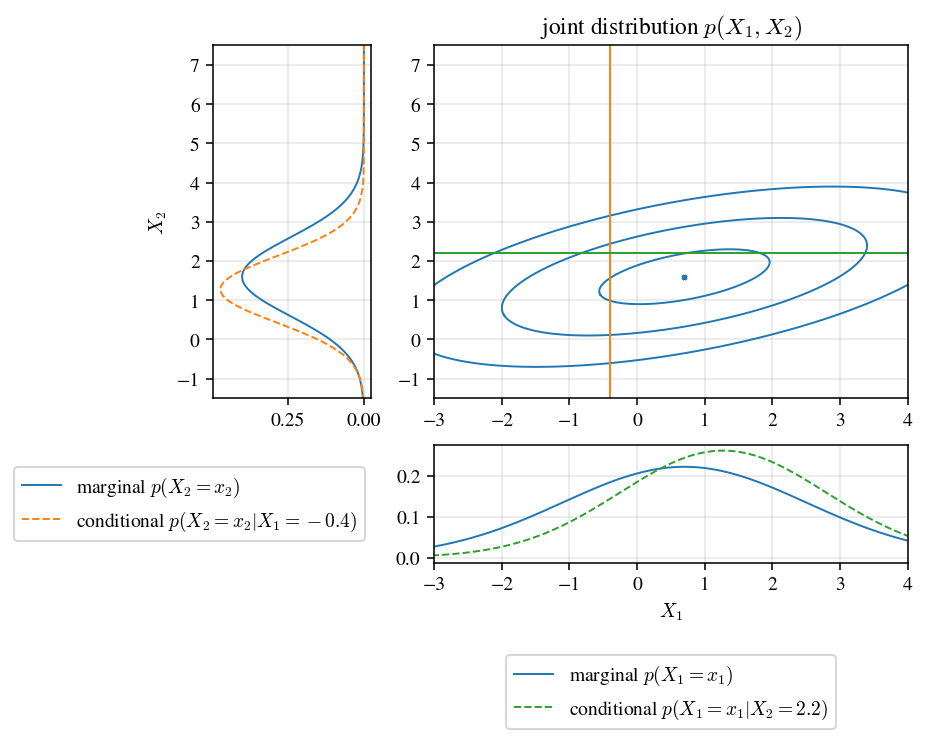

In [ ]:
#@title Multivariate normal interactive excercise 2 {run: "auto"}

from matplotlib import gridspec
from scipy.stats import norm

μ1 = 0.7 #@param {type:"slider", min:-5, max:5, step:0.1}
σ1 = 1.8 #@param {type:"slider", min: 0.1, max:4, step:0.1}
μ2 = 1.6 #@param {type:"slider", min:-5, max:5, step:0.1}
σ2 = 1 #@param {type:"slider", min: 0.1, max:4, step:0.1}
ρ = 0.529 #@param {type:"slider", min: -0.999, max:0.999, step:0.001}
x1 = -0.4 #@param {type:"slider", min:-5, max:5, step:0.1}
x2 = 2.2 #@param {type:"slider", min:-5, max:5, step:0.1}

μ = jnp.array([μ1, μ2])
Σ = jnp.array([[σ1**2, ρ*σ1*σ2],[ρ*σ2*σ1, σ2**2]])

cond_μ_x1, cond_σ_x1 = Gaussian_conditional(μ, Σ, x=None, y=x2)
cond_μ_x2, cond_σ_x2 = Gaussian_conditional(μ, Σ, x=x1, y=None)

xrange = jnp.linspace(-10, 10, 300)
density_x1 = norm.pdf(xrange, μ1, σ1)
density_x2 = norm.pdf(xrange, μ2, σ2)

cond_density_x1 = norm.pdf(xrange, cond_μ_x1, cond_σ_x1)
cond_density_x2 = norm.pdf(xrange, cond_μ_x2, cond_σ_x2)

plt.figure(dpi=140)
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

plot_log_gaussian_ellipse(ax, μ, Σ, color='C0', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[0.7, 1.5, 2.3])
ax.set_title('joint distribution $p(X_1, X_2)$')
ax.axvline(x1, lw=1, c='C1')
ax.axhline(x2, lw=1, c='C2')

axb.plot(xrange, density_x1, c='C0', lw=1, label='marginal $p(X_1=x_1)$')
axb.plot(xrange, cond_density_x1, '--', c='C2', lw=1, label=f'conditional $p(X_1=x_1 | X_2={x2})$')
axb.set_xlabel('$X_1$')
axb.set_xlim([-3,4])
axb.legend(bbox_to_anchor=[0.5, -1.1],
           loc='center')

axl.plot(density_x2, xrange, c='C0', lw=1, label='marginal $p(X_2 = x_2)$')
axl.plot(cond_density_x2, xrange, '--', c='C1', lw=1, label=f'conditional $p(X_2 = x_2 | X_1={x1})$')
axl.set_ylabel('$X_2$')
axl.set_ylim([-1.5,7.5])
axl.invert_xaxis()
axl.legend(bbox_to_anchor=[-0.15, -0.3],
           loc='center')

ax.grid(alpha=0.3)
axl.grid(alpha=0.3)
axb.grid(alpha=0.3)
plt.show()

###### Answer to group task A13

1. If $\rho = 0$, the conditional distributions match the marginal distributions, since conditioning on an independent variable has no affect.
2. As $\rho \rightarrow 1$, the value of the conditional distribution becomes more and more influenced by the value of the conditioning variable. If both means are 0, and both standard deviations are 1, then the conditional distribution converges to the values of the conditioning variable.
3. The smaller the ratio, i.e., the less (relatively) confident we are about the conditioning variable, the less the conditioning variable affects the conditional distribution.
4. $\rho$ does not affect the marginal distributions.

### Batch and event shapes

Let's take a moment to play with some code for both the multivariate normal and its simpler friend the univariate normal. We'll take this opportunity to learn something about how `numpyro` (and most other packages for working with probability distributions) handle batches of data – something we'll have to understand for training machine learning models!

All distributions in `numpyro` have an `event_shape` – which describes how my dimensions the random variable is, e.g., for a 2-dimmensional normal distribution this would be 2 – and a `batch_shape` which describes how many sets of parameters the distribution has – it is probably easier to show what this means with the following examples rather than tell.

Let's first look at a simple univariate normal $\mathcal{N}(x|0, 1)$, as we've seen before in this practical. We will evaluate the probabilities of $X = 1$ and $X = 2$:

In [ ]:
values = jnp.array([1., 2.])
normal = dist.Normal(0., 1.)
print(f"event_shape = {normal.event_shape}")
print(f"batch_shape = {normal.batch_shape}")
print(f"p(X = {values}) = {jnp.exp(normal.log_prob(values))}")

event_shape = ()
batch_shape = ()
p(X = [1. 2.]) = [0.24197073 0.05399096]


We see that this distribution has an empty event shape, which you can think of as being the same as an event shape of 1 (like how a scalar is the same as vector of length 1). The batch shape is also empty, since we only specified one set of parameters ($\mu = 0, \sigma = 1$).  

Now since we tried to evaluate the probability of two values at once, and neither the event shape nor the batch shape are 2, this is equivalent to calling `dist.log_prob(1.)` and `dist.log_prob(2.)` separately. `numpyro` is just making our lives easier by *broadcasting* the `log_prob` calculation to do both $p(X=1) = \mathcal{N}(X=1|0, 1)$ and $p(X=2) = mathcal{N}(X=2|0, 1)$ at the same time.

We could also specify a *batch* of two sets of parameters so that we are essentially working with $\mathcal{N}(x|0, 1)$ and $\mathcal{N}(x|1, 2)$ at the same time:

In [ ]:
batch_normal = dist.Normal(jnp.array([0., 1.]), jnp.array([1., 2.]))
print(f"event_shape = {batch_normal.event_shape}")
print(f"batch_shape = {batch_normal.batch_shape}")
print(f"[p(X_1 = {values[0]}), p(X_2 = {values[1]})] = {jnp.exp(batch_normal.log_prob(values))}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.prod(jnp.exp(batch_normal.log_prob(values)))}")

event_shape = ()
batch_shape = (2,)
[p(X_1 = 1.0), p(X_2 = 2.0)] = [0.24197073 0.17603266]
p(X_1 = 1.0, X_2 = 2.0) = 0.042594753205776215


Now, notice that while the event shape is empty (as expected since we are still working with a univariate normal), the batch size is 2!

As a result, the calculation we are doing is equivalent to separately calculating $p(X_1=1) = \mathcal{N}(X_1=1|0, 1)$ and $p(X_2=2) = \mathcal{N}(X_2=2|1, 2)$! Again, this is just `numpyro` making our lives easier.

If we want to calculate $p(X_1=1,X_2=2)$, i.e., the joint probability that $X_1 = 1$ and $X_2 = 2$, then we either need to manually multiply the probabilities (assuming that $X_1$ and $X_2$ are independent) – as we've in the cell above – or we need to work with a multivariate normal.

Let's first look at the case when the $X_1$ and $X_2$ are independent:

In [ ]:
multivariate_diagonal_normal = dist.MultivariateNormal(jnp.array([0., 1.]), jnp.array([[1., 0.], [0., 2.**2]]))
print(f"event_shape = {multivariate_diagonal_normal.event_shape}")
print(f"batch_shape = {multivariate_diagonal_normal.batch_shape}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]})) = {jnp.exp(multivariate_diagonal_normal.log_prob(values))}")

event_shape = (2,)
batch_shape = ()
p(X_1 = 1.0, X_2 = 2.0)) = 0.042594753205776215


As expected, for this 2-dimmensional normal, we now have an event size of 2! And because we only specified one set of parameters, the batch shape is empty.

As a result of this event shape, when we ask for the `log_prob` of our two numbers, we automatically get a single *joint* probability, which matches the value we manually calculated above.

Using a multivariate normal, we can also introduce some convariance between $X_1$ and $X_2$:

In [ ]:
multivariate_full_normal = dist.MultivariateNormal(jnp.array([0., 1.]), jnp.array([[1., 1.], [1., 2.**2]]))
print(f"event_shape = {multivariate_full_normal.event_shape}")
print(f"batch_shape = {multivariate_full_normal.batch_shape}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.exp(multivariate_full_normal.log_prob(values))}")

event_shape = (2,)
batch_shape = ()
p(X_1 = 1.0, X_2 = 2.0) = 0.055732980370521545


This results in a slightly different value for the joint probability, but otherwise eveything looks the same.

Of course, we can get a bit crazy and we can have non-empty event shape *and* a non-empty batch shape, but we'll leave that as a homework excercise for the curious to play with.

## The beta distribution


The final distribution on our *grand tour of probability distributions* is the beta distribution. We're taking a look at this for two reasons. Firstly, we just want to take a looks at a continuous probablility distribution that *isn't* normal, for the sake of getting some new perspective. Secondly, this distribution will be useful later in the practical – so if you aren't already familiar with it, stick around for this section.

The beta distribution can be used to describe a continuous random variable between 0 and 1, for example percentages and ratios. It has the following form
$$
p(X = x) = \mathrm{Beta}(x|\alpha,\beta) = \frac{1}{\mathrm{B}(\alpha,\beta)}x^{\alpha-1}(1 - x)^{\beta - 1},
$$
where $\alpha > 0$ and and $\beta > 0$ are the two *shape* parameters of the distribution, and $\mathrm{Beta}$ is called the beta function. Don't worry about the exact form of the beta function, all you need to know is that we can easily compute it using `numpy` or similar libraries, and it just ensures that the probability distribution is normalised – that is, that the total probability of all of the events adds up to 1. Instead, let's play around with the following sliders to get an idea of what the beta distribution looks like.
* Try making each parameter big or small while leaving the other at the same value.
* Then try make them both big or small.

We're just trying to get a feel for the kinds of behaviour the beta distribution can describe, and how it is different from the normal distribution. Later on we'll use the beta distribution in an example which will help us get some further intuition for this distribution.

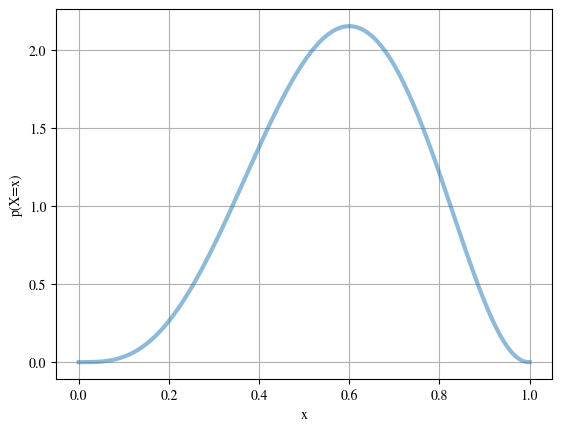

In [ ]:
#@title beta distribution interactive excercise {run: "auto"}
α = 4.3 #@param {type:"slider", min:0.1, max:10, step:0.1}
β = 3.2 #@param {type:"slider", min:0.1, max:10, step:0.1}

beta = dist.Beta(α, β)
xs = jnp.linspace(0, 1, 1000)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, jnp.exp(beta.log_prob(xs)), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.grid(0.3)
plt.show()

## The (continuous) uniform distribution

For the sake of completeness, let's formally introduce one of the most simple continuous distributions – the uniform distribution. Under this distribution, all possible values are equally likely. The uniform distribution has the following form
$$
p(X = x) = \mathrm{Uniform}(x\mid a, b) = \begin{cases}
\frac{1}{b - a}\, & \text{if } a \le x \le b \\
0\, & \text{otherwise},
\end{cases}
$$
where $a$ and $b$ are the upper and lower bound parameters, respectively.

As has been our custom, here is an interactive plot of the distribution if you'd like to get a better picture.

<ipython-input-37-612be9131742>:11: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  ax.plot(xs, jnp.exp(uniform.log_prob(xs)), color='C0', lw=3, alpha=0.5)


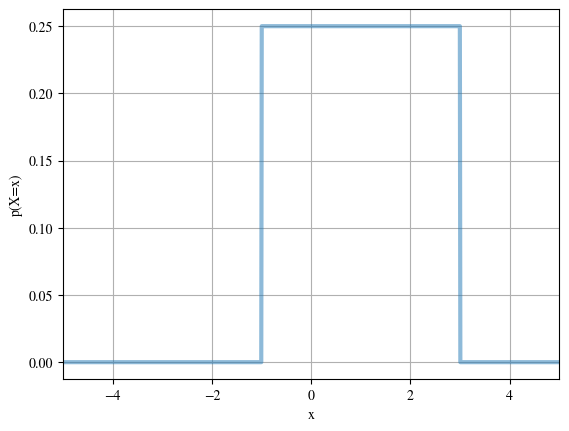

In [ ]:
#@title uniform distribution interactive excercise {run: "auto"}
#@markdown Note: `a` must be smaller than `b`.
a = -1 #@param {type:"slider", min:-5, max:5, step:0.1}
b = 3 #@param {type:"slider", min:-5, max:5, step:0.1}

uniform = dist.Uniform(low=a, high=b)
xs = jnp.linspace(-5, 5, 1000)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, jnp.exp(uniform.log_prob(xs)), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.grid(0.3)
ax.set_xlim(-5, 5)
plt.show()

## [Optional] comparing distributions with the KL divergence – <font color='orange'>`Intermediate`</font>

Now that we've seen a few different distributions, and also seen how varied the behaviour of a single distribution can be depending on the setting of the parameters, let's take the opportunity to think about how to compare distributions mathematically.

We're going to use a tool called the Kullback–Leibler (KL) divergence as a *metric* to compare two distributions, $p$ and $q$:
$$
D_\mathrm{KL}\left[p\mid\mid q\right] = \mathbb{E}_{x\sim p}\left[-\log\frac{q(x)}{p(x)}\right].
$$
We can think of the KL divergence as taking a number of samples $x$ from $p(X)$ and then comparing how likley those samples are under $q$ and $p$. A few things to note about the KL divergence:
1. If $D_\mathrm{KL}\left[p\mid\mid q\right] = 0$, then $p$ and $q$ are the same distribution.
2. $D_\mathrm{KL}\left[p\mid\mid q\right] \ne D_\mathrm{KL}\left[q\mid\mid p\right]$, in general.
3. If $p(X)$ is not 0 wherever $q(X) = 0$, then then $D_\mathrm{KL}\left[p\mid\mid q\right] = \infty$. This means that the support of $q(X)$ must contain the support of $p(X)$ if we want to use the KL divergence to compare distributions.
4. For some simple cases (i.e., normal + normal) the formula above can be written in an exact form without the expectation.

Let's take a look at a simple implementation of the KL divergence:

In [ ]:
def kl_divergence(p: dist.Distribution, q: dist.Distribution, n: int = 10_000):
    xs = p.sample(rng, sample_shape = (n,))
    p_log_probs = p.log_prob(xs)
    q_log_probs = q.log_prob(xs)

    return -(q_log_probs - p_log_probs).mean()

**Group task 14:** Use the `kl_divergence` function above, as well as `dist.Normal`, `dist.Uniform`, and `dist.Beta`, to answer the following questions.

1. Calculate the following KL divergence. What do we see?
  * $D_\mathrm{KL}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Uniform}(0, 1)\right]$
  * $D_\mathrm{KL}\left[\mathrm{Beta}(5, 2) \mid\mid \mathrm{Beta}(5, 2)\right]$
2. Calculate the following KL divergences. What can we say about the relationship between the beta and uniform distributions?
  * What is $D_\mathrm{KL}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(5, 2)\right]$?
  * What is $D_\mathrm{KL}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(2, 2)\right]$?
  * What is $D_\mathrm{KL}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(1, 1)\right]$?
3. What is $D_\mathrm{KL}\left[ \mathrm{Beta}(5, 2) \mid\mid \mathrm{Uniform}(0, 1)\right]$. How does it compare to $D_\mathrm{KL}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(5, 2)\right]$ from above?
4. Compare $D_\mathrm{KL}\left[\mathrm{Uniform}(-1, 1) \mid\mid \mathcal{N}(0, 1)\right]$ and $D_\mathrm{KL}\left[\mathcal{N}(0, 1) \mid\mid  \mathrm{Uniform}(-1, 1) \right]$.

### Answer to group task A14

1. Both KL divergences are 0, since $p = q$.
2. As the beta distributions shape parameters both get closer to 1, the KL divergence gets smaller, until the KL divergence becomes $\approx 0$, when both shape parameters are 1. This means that ${Beta}(1, 1)$ is a uniform distribution between 0 and 1.
3. As expected, $D_\mathrm{KL}\left[ \mathrm{Beta}(5, 2) \mid\mid \mathrm{Uniform}(0, 1)\right] \ne D_\mathrm{KL}\left[ \mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(5, 2)\right]$
4. While the first KL divergence is valid, the second is $\infty$.

### [Optional] A note on notation: KL divergences

* The KL divergence is also written simply as $\mathrm{KL}$.
* The double bar '$\mid \mid$' is simply a notation choice, and doesn't realted to the single bar '$\mid$' in conditional probability distributions.
* We read $D_\mathrm{KL}\left[p \mid\mid q\right]$ as 'the KL divergence between p and q', or alternatively 'the KL divergence from **q** and **p**' to reflect the asymmetry.
* The KL divergence is also called the *relative entropy*.

# Part B: Bayesian inference: What, Why, How - [<font color='blue'>`Beginner`</font>] /[<font color='orange'>`Intermediate`</font>]

_Note: Most of this section is aimed at an *[<font color='orange'>`Intermediate`</font>]* level, however the initial conceptual content is certified [<font color='blue'>`Beginner`</font>] friendly! 🤙 So if you are a beginner but have gotten to this section: firstly, well done 🥳, and secondly, see how far you can get up until the **point estimates** section. If you have some knowledge of calculus and optimisation, the point estimates section will also be accessible. Remember to ask your tutors for help if you get stuck along the way!_

**What you will learn:**

- What is Bayesian inference?
- Why do we care?
- How to perform Bayesian inference: a painful way and a modern way. 😮

## *What* is Bayesian inference? - [<font color='blue'>`Beginner`</font>]


In short, Bayesian inference is the process of deducing properties of a probability distribution from data using Bayes’ theorem. It incorporates the idea that probability should include a measure of <font color='purple'>`belief`</font> 💭 about a prediction or outcome.


Bayesian inference is a method of statistical inference in which probability is used to <font color='purple' >`update beliefs`</font> about model's parameters based on available <font color='red'>`evidence or data`</font> 📁.

**Group task 1:**

To better undertand the role of prior <font color='purple'>`beliefs and subjective probability`</font>, discuss with your neighbour the following questions:


- What is the probability that it will rain tomorrow?
- What is the probability that the next president will be a woman?
- What is the probability that aliens built the pyramids?

How do these questions compare to the probability that a die will roll a 6?

Such questions, unlike the die, cannot be answered by "long-run" probability, i.e. probability obtained from multiple repeated runs of the same experiment. A certain degree of <font color='purple'>`belief`</font> 💭 is involved.

<font color='purple'>`Priors`</font> 💭 and "subjective" probability are foundational for Bayesian inference!


## Bayes' Theorem 😻 - [<font color='blue'>`Beginner`</font>]

_Note: Conditional probability is the axis on which Bayesian statistics turns! If you skipped this section in the first part of the practical and need a refresher on joint and conditional probabilities, go back to that bit of the prac to make sure you are ready for the phenomenon of Bayes' Theorem!_

From the joint and conditional formulae, we can relate two conditional probabilities:

\begin{equation}
P(B \vert A) = \frac{P(A \vert B)P(B)}{P(A)}
\end{equation}

This is the same equation you have already explored...

...but with a slightly different interpretation.

**The famous Bayes Theorem!** 😻

Why is it so famous? Well let's understand what it means and gives us first!

### Prior, likelihood and posterior

Bayes' Theorem is commonly seen in machine learning and other models using <font color='red'>`data or evidence`</font> $\mathcal{D}$ and <font color='purple'>`parameters`</font> $\theta$ as:

\begin{equation}
P(\theta \vert \mathcal{D}) = \frac{P(\mathcal{D} \vert \theta)P(\mathcal{\theta})}{P(D)}
\end{equation}

* The denominator $P(\mathcal{D})$ is often called a *normaliser* or <font color='red'>`evidence`</font> .
* $P(\mathcal{\theta})$ is the <font color='purple'>`prior`</font> .
* $P(\mathcal{D} \vert \theta)$ is the <font color='teal'>`likelihood`</font> .
* and $P(\theta \vert \mathcal{D})$ is the <font color='pink'>`posterior`</font>.

For this reason, you will often see Bayes rule summarised as "<font color='pink'>`posterior`</font> $\propto$ <font color='purple'>`prior`</font> $\times$ <font color='teal'>`likelihood`</font> ", which ignores the denominator since it is a constant (independent of $\mathcal{D}$). This posterior summarises our belief state about the possible values of $\theta$.

**Group task 2:** _Switch $A$ and $B$ in $
P(B \vert A) = \frac{P(A \vert B)P(B)}{P(A)}$ and label what is the posterior, likelihood, prior and evidence in the new equation. Explain what each means to each other a few times to be sure you know what goes where! _Often the literature will refer to these 'labels' and require you know them already, so while they might seem arbitrary this memorisation task goes a long way to making your life easier in practice!_

#### Answer to group task B2

In a picture format:

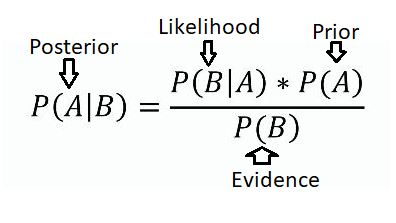


To reiterate:

- Prior is what is known or estimated a priori
- Likelihood is probability of data given parameters of interest
- Posterior is probability of parameters of interest given data

### Bayesian inference: examples and intuition

Let's get to grips with these concepts a bit more by thinking about some everyday examples!


### Example: diagnosing the cause of headache

<div align="center">

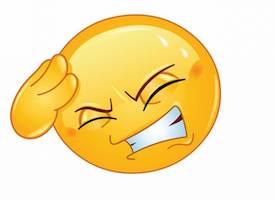
</div>

Imagine a situation where you need make a decision concerning your health. You have a headache, and can choose between two doctors:

**Doctor 1:**
- Has a mental model for the cause of pain.
- Performs tests.

**Doctor 2:**
- Has a mental model for the cause of pain.
- Has access to the patient's chronic history.
- Performs tests.

Which doctor do you choose? Can you make sense of which parts are the <font color='red'>`data`</font>, <font color='teal'>`likelihood`</font> and <font color='purple'>`prior`</font> in this scenario?

Inference without priors is like a doctor who does not know the patient's history!

### Task: diagnosing COVID 🤢

**Group task 3:** We know that the probability of having fever this time of the year is 10%, the probability of having COVID is 7%, and among all people who have COVID, 70% of them have fever.

If you're a doctor, you don't know whether someone has COVID until you test them, but they may present with a high temperature and you want to reason whether to isolate them on that basis! So you are interested in knowing the chance that someone has COVID given they have a high temperature.

Find the probability that a patient has COVID given they have high temperature (fever).

#### Hint

Again, make sense of which parts are the <font color='red'>`data`</font>, <font color='teal'>`likelihood`</font> and <font color='purple'>`prior`</font> in this scenario and use Bayes' Theorem!

For two simple events, Bayes' theorem can be written as

$$ p(A|B) = \frac{p(B|A) p(A)}{p(B)}.$$

#### Answer to group task B3

Write out your probabilties, with $F$ for **F**ever and $C$ for **C**OVID.

We want the <font color='pink'>`posterior`</font> $p(C \vert F)$.

<font color='teal'>`likelihood`</font>: $p(F \vert C) = 0.7$ \\
 <font color='purple'>`prior`</font>: $p(C) = 0.07$ \\
<font color='red'>`data`</font>: $p(F) = 0.1$

Combining these with Bayes' Rule:
\begin{eqnarray*}
 p(C|F) &=& \frac{p(F|C) p(C)}{p(F)} \\
 &=& \frac{0.7 \cdot 0.07}{0.1} \\
 &=& 0.49
\end{eqnarray*}

So almost half of the patients seen with fever are likely to have COVID!

### Choosing the  <font color='purple'>`prior`</font> distribution

In the doctor example, if the doctor we go to has access to history, but only from when the patient was a child and not for their recent years as an adult, they might make the wrong inferences about the current cause of a headache. For example, if they don't know that the patient was in a car accident last month and banged their head, they could get the cause of the headache very wrong! 🥴

The choice of the  <font color='purple'>`prior`</font> 💭 is really important! It can depend on a few things:

- Type of distribution (we will see this in a second)
- Hyperparameters/hyperpriors
- Often there is a 'natural' candidate for prior choice
- Whether it creates a posterior that is mathematically solvable or not
- Some do (conjugate <font color='purple'>`prior`</font>)
- Most do not (non-conjugate)...

### Exploring the influence of <font color='purple'>`priors`</font>

Let us explore how much <font color='purple'>`priors`</font>  can actually influence the posterior. Since tha marginal distribution $p(y)$ does not depend on the parameters, we will only explore the posterior up the to proportionality term.

$$p(\theta |y ) ∝ p(y| \theta) p(\theta).$$

If we have access to point-wise evaluations of the <font color='teal'>`likelihood`</font> $p(y | \theta)$ and prior $p(\theta)$, we can compute their product to obtain this posterior.

Consider the coin tossing problem, which we describe using the Bernoulli distribution for a single trial, and the product of Bernoullis for multiple trials. When we compute a <font color='teal'>`likelihood`</font> by multiplying independent Bernoulli trials, this is like a *permutation* in so far as the *order* of the tosses matters.

Another formulation for a repeated Bernoulli random variable is to consider the _proportion_ of correct trials without considering order. We can normalise for this using the formula for combinations, which you may know of as "$n$ choose $k$." This lets us define a random variable on the number of succeses in $n$ trials called a **Binomial random variable**.

Let's say that out of
$$n=10$$
tosses we obtained
$$h=6$$
successes.

Let's consider: what is the probability of "success" for this coin? We'll simulate some examples using a binomial random variable.

**[Optional]:** *Show that the <font color='teal'>`likelihood`</font> for coin tosses calculated using independent Bernoulli random variables (a Bernoulli process) is proportional (up to a constant) to the likelihood for coin tosses calculated using a Binomial random variable.*

#### Code to compute the posterior (run this, but you can leave this hidden)

In [62]:
##############################################
# prior x likelihood = posterior
##############################################

h=6
n=9
p=h/n

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood_pmf = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

In [61]:
def computePosterior(likelihood, prior):
    # this functionm computes posterior
    # and plots the result

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()

    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    ax1.grid(0.3)
    plt.plot(p_grid, prior,color='purple')

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    ax2.grid(0.3)
    plt.plot(p_grid, likelihood,color='teal')

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior,color='gray')
    ax3.grid(0.3)
    plt.show()

    return

#### <font color='purple'>`Prior`</font> 1 - Uniform

Our first <font color='purple'>`prior`</font> will be a Uniform distribution:

$$p(\theta) = 1.$$

This means we don't think the coin is likely to be weighted or not: the probability of heads could take any value between 0 and 1 equally.

This is the same as not having a prior at all! So we should expect the likelihood and posterior distributions to look the same (if that isn't intuitive to you, speak to a tutor).

Run the code cell below to confirm your intuitions.

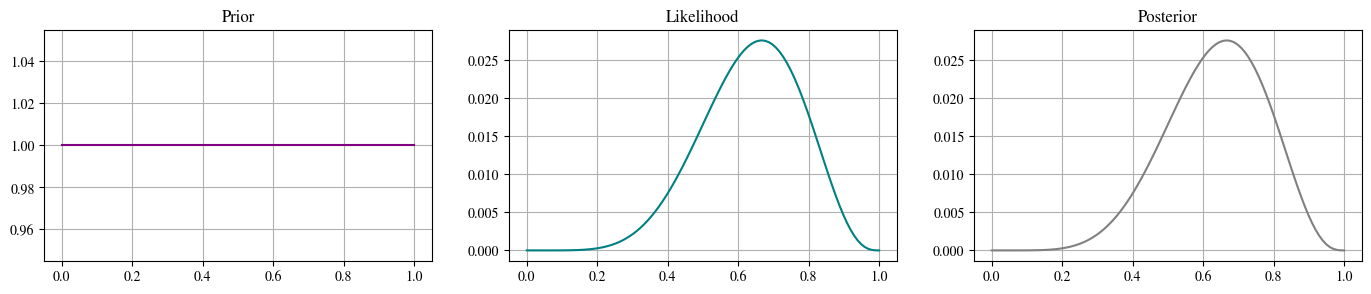

In [53]:
# Uniform prior
prior1 = jnp.repeat(1, grid_points)

# visualise prior, likelihood, posterior
posterior1 = computePosterior(likelihood_pmf, prior1)

#### **<font purple='yellow'>`Prior`</font> 2 - Step-function**

Perhaps we are pretty sure that heads is more likely than tails i.e. the coin is weighted, but we don't know by how much.

We could set this up as a step-function where the probability is 0 below a certain value, and uniform after.

**Code task B4**: Implement the step-function prior:

$$p(\theta) = 1.$$

$$
p(\theta) = \begin{cases}
0 \text{ if } \theta <= 0.5 \\
1 \text{ otherwise. }
\end{cases}
$$

How do you think the posterior will change? Sketch the prior to give yourself some intuition!


In [55]:
#@markdown *Hint:* Try to reset the value of the prior greater than 0.5 to 1 and less than or equal to to 0. You could use `jnp.round` or `.astype`; you can also just code from scratch ignoring the helper code (remembering to have `grid_points` data points!)

def step_prior(gridpts = grid_points):
  # define regular grid in the (0,1) interval -- this will step from 0 to 1 in intervals, you could modify this for your answer but you do not have to
  p_grid = jnp.linspace(0, 1, gridpts)
  prior2 = ### fill in your code here ###
  prior2 =
  return prior2


SyntaxError: ignored

##### Run this to test your code!

In [54]:
#@markdown Run this to test your code!
def correct_step(gridpts = grid_points):
  s_prior=step_prior()
  p_grid = jnp.linspace(0, 1, gridpts)
  correct = False
  if (s_prior == ((p_grid >= 0.5).astype(int))).all():
    correct = True
  elif (s_prior == (jnp.round(p_grid,0))).all():
    correct = True
  return correct

cs = correct_step()

if cs == True:
  print('Correct! Here is what the posterior looks like:')
else:
  print('That is not quite right; try again. Here is what the posterior looks like:')
posterior2 = computePosterior(likelihood, step_prior(gridpts = grid_points))

NameError: ignored

##### Answer to coding task B4

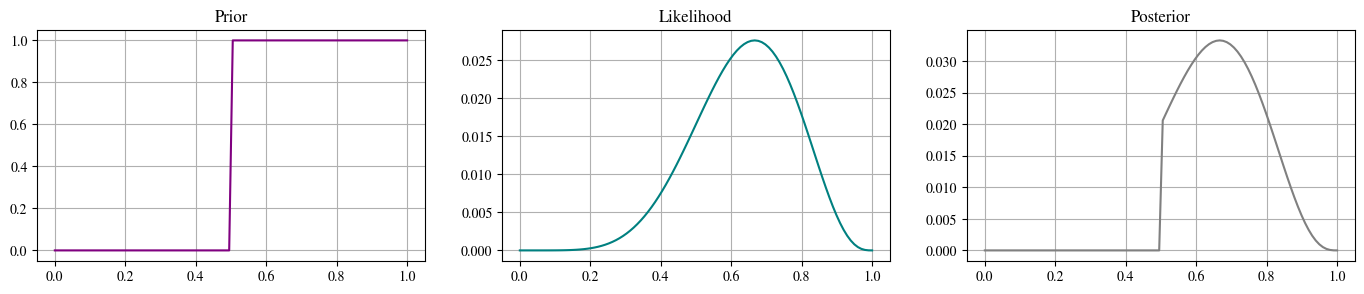

In [57]:
prior2 = (p_grid >= 0.5).astype(int)
posterior2 = computePosterior(likelihood_pmf, prior2)

#### <font color='purple'>`Prior`</font> 3 - Custom prior centered at 0.5

Let's imagine some prior that is centered at 0.5, and decays (exponentially) on either side. Run the below code and validate that this prior looks like you would expect, and shifts the likelihood to the posterior as you would expect.

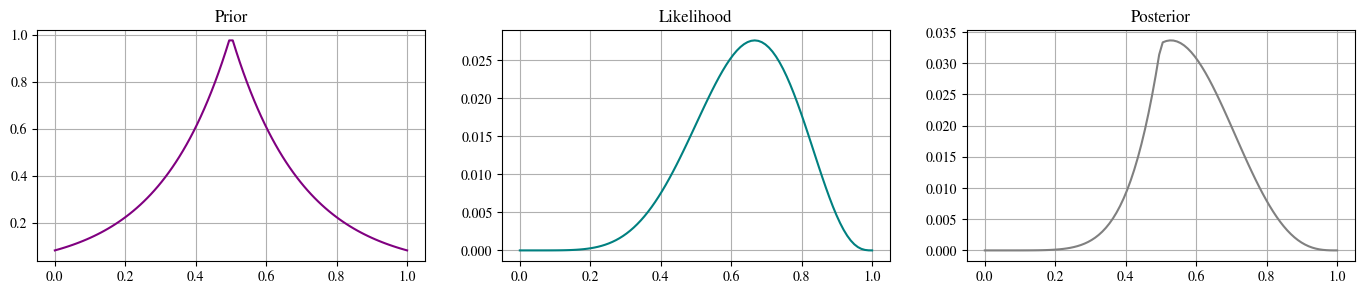

In [59]:
prior3 = jnp.exp(- 5 * abs(p_grid - 0.5))
posterior3 = computePosterior(likelihood_pmf, prior3)

**Group task 5**: Does it matter if the priors or likelihood are true probability distributions, that is that they sum to 1? Why not? For Bayesian inference (our posterior), does it matter?

##### Answer to group task B5

No it does not matter if the pmfs do not sum to 1. For Bayesian inference, i.e. finding the posterior, normalising is just a proportional constant!

#### Informative or non-informative priors

Choosing a prior is hard!

- Main source of criticism from non-Bayesians is how priors are chosen.
- Priors should be informed by existing knowledge.
- But what if we don't know anything before (prior to) inference?
- Non-informative/informative priors are outside scope of this section, but something to pay attention to when you encounter these models in the wild! 🐅

## *How* can we perform true Bayesian inference? - [<font color='orange'>`Intermediate`</font>]

### What does it take?
- <font color='red'>`Data`</font>
- A generative model (how does the conditional <font color='teal'>`likelihood`</font> come about?)
- Our <font color='purple'>`beliefs`</font> before seeing the data.

### What does it make?
- The values of parameters that could give rise to the observed data **in the form of a distribution**.

### *How* can we perform Bayesian inference?

- **Analytically**
        
     Solving the maths! This is an elegant approach. However, it is rarely available in real life.

- **Numerically**

    - Rather than deriving a posterior distribution in the closed form, we can use computational tools to **sample** from the posterior. The obtained samples describe the distributions of parameters.
    
    - We achieve this by exploring the space of parameters to find the most probable combinations of parameters.
    
    - Further we treat the obtained sampled as new data, to extract information about parameters, such as mean, credible interval or other statistics.

## Numerically

- Markov Chain Monte Carlo (MCMC) family of algorithm, e.g.
  * Metropolis-Hastings
  * Gibbs
  * Hamiltonian Monte Carlo (HMC)
  * No-U-Turn sampler (NUTS)
  * further variants such as SGHMC, LDHMC, etc
- Variational Bayes
- Approximate Bayesian Computation (ABC)
- Particle filters
- Laplace approximation

More on this later! First, let's discuss some analytics and point estimates.

## Analytical Bayesian inference: Point estimates for Bernoulli-beta coin flips - [<font color='orange'>`Intermediate`</font>]

### Point estimates

To illustrate the use of Bayes' Theorem further, let's explore the coin flip example that you saw with the Bernoulli distribution to try to figure out whether a coin is weighted or not. 💰

We really just want one answer out of this problem -- the probability that a coin will give us a heads (since we know that the probability of tails is just $1- P(heads)$). This is a <font color='green'>`point estimate`</font>: one answer out of a range.

In machine learning, we are often interested in estimating parameters $\theta$ that best allow us to describe our data. Generally this leads to solving some optimisation problem for a loss function $\mathcal{L}$, i.e.
\begin{equation*}
\hat{\theta} = {\arg \min}_\theta \mathcal{L}(\theta)
\end{equation*}

This gives us a <font color='green'>`point estimate`</font> $\hat{\theta}$.

**Group task 6**: Does a point estimate tell us anything about our uncertainty or the distribution from which we draw the estimate? Discuss the difference between <font color='green'>`point estimates`</font> and estimating a *distribution*.

#### Answer to group task B6

No. Point estimates _assume_ there is a true but unknown value of the parameters we want to find. We use (Bayesian) inference (which noteably here isn't the same as inference in the prediction sense) to incorporate uncertainty. Inherently, we represent this as randomness, and rather than find the true value of the parameter, we look for its distribution in the posterior $p(\theta \vert \mathcal{D})$.

### Maximum likelihood estimation

We might want to choose the point estimate of parameters that maximises the probability that our model describes the training data. This is called **<font color='teal'>`maximum likelihood estimation`</font>** (MLE), and is what one most commonly does when fitting point estimates for parameters.

\begin{equation*}
\hat{\theta}_{MLE} := {\arg \max}_{\theta} p(\mathcal{D} \vert \theta)
\end{equation*}

Let's apply this to coin tosses, using what we already know about distributions from the first section of the practical. 😸



#### MLE for a Bernoulli process

First, some maths. Let's assume we have some $N$ coin flips, which we can assume are independent, where $H=1$ is a flip resulting in heads and $H=0$ tails. Let's denote the random variable for the flip on trial $i$ by $h_i$.

We can model this as a Bernoulli process, like we did in the first section of this notebook. Given $n$ trials (coin flips), we want to compute the MLE parameter that tells us whether the coin is weighted or not: what is the proportion or likelihood of getting heads, $P(H=1) = \theta$?

**Group task 7**: Write down the **<font color='teal'>`negative log likelihood`</font>** ($NLL(\theta)$) for this problem. Try to simplify as far as you can go!

#### Hint

Break down what this means -- likelihood means $p(H \vert \theta)$, log means logarithm, and negative means multiplying something by -1 (ask your instructor if you don't know why we do these steps, they each make our jobs in computing probabilities easier!).

#### Answer to group task B7

Think of the **likelihood** bit first: this is just $p(H \vert \theta)$ from our definition above. We have $N$ trials and they are independent, so the overall likelihood is going to be the product of the likelihood on each trial, $p(h_i \vert \theta)$:

\begin{eqnarray*}
\mathcal{L}(\theta) = \prod_{i=1}^N p(h_i \vert \theta)
\end{eqnarray*} \\

Now we can combine the likelihood with the **negative log** bit and what we know about the form of the Bernoulli distribution to get:

\begin{eqnarray*}
NLL(\theta) &=& - \log \prod_{i=1}^N p(h_i \vert \theta) \\
&=& -\log \Bigg[ \prod_{i=1}^N \theta^{h_i} (1-\theta)^{(1-h_i)} \Bigg] \\
\end{eqnarray*} \\

Using the properties of the logarithm (remember, these turn products into sums!):

\begin{eqnarray*}
NLL(\theta) &=& - \sum_{i=1}^N \bigg[h_i \log(\theta) + (1-h_i)\log(1-\theta)\bigg] \\
&=& - \Bigg[\sum_{i=1}^N h_i \Bigg] \log(\theta) - \Bigg[\sum_{i=1}^N 1-h_i \Bigg]\log(1-\theta) \\
\end{eqnarray*} \\

Now the Bernoulli R.V.s $h_i$ are defined as either 0 or 1, depending in this case on whether each is heads or tails. So when we are summing over them we are really _counting_ the number of heads and tails (which remember is the same as $N-$ number of heads) across all the trials!

Let's call the number of heads $N_1$ and the number of tails $N_0$. Then the negative log likelihood becomes:

\begin{eqnarray*}
NLL(\theta) &=& - N_1 \log(\theta) - N_0 \log(1-\theta) \\
&=& - \Big[ N_1 \log\theta + N_0 \log(1-\theta)\Big]
\end{eqnarray*}

#### MLE by hand
We can implement this in code to find the **<font color='teal'>`maximum likelihood estimation`</font>** ($\arg \max_\theta NLL(\theta)$), but we can also go a bit further and try to simplify the equation we have found via optimisation. We want to minimise the NLL, so we can set the derivative of the quantity to 0 and then solve.

**Group task 8**: Find the MLE by solving the optimisation problem $\frac{d}{d\theta} NLL(\theta) = 0$. Does the answer make sense to you?

##### Hint

How to derive the MLE estimate with words? (This will help if you don't completely understand the derivation below 😸)

$$L (\theta) = \theta^\text{heads} (1-\theta)^\text{tails}  $$


$$\log L (\theta) = \text{heads} * \log \theta +  \text{tails} * \log (1-\theta)  $$

$$ \frac{d \log L}{ \ d \theta} = \frac{\text{heads}}{\theta} + \frac{\text{tails}}{1-\theta} = 0 $$

and so

$$ \hat{\theta} = \frac{\text{heads}}{\text{heads + tails}} $$

#### Answer to group task B8

Diving in:

\begin{eqnarray*}
  0 &=& \frac{d}{d\theta} NLL(\theta) \\
  &=& \frac{d}{d\theta} \bigg[ - \Big[ N_1 \log\theta + \big[N_0-N\big] \log(1-\theta)\Big]\bigg] \\
  &=& -N_1 \frac{d}{d\theta}\big[\log\theta\big] -N_0 \frac{d}{d\theta} \big[\log(1-\theta)\big]\\
\end{eqnarray*} \\

You need to remember the univariate chain rule and derivative of logarithm to do the next step! Just look them up if you've forgotten! 🤭

\begin{eqnarray*}
  0 &=& -\frac{N_1}{\theta} + \frac{N_0}{1-\theta} \\
  &\implies & \hat{\theta}_{MLE} = \frac{N_1}{N_1+N_0} = \frac{N_1}{N}
\end{eqnarray*} \\


This answer is just the (empirical i.e. experimental) fraction of heads that we flipped across all $N$ trials -- that should make sense!

#### Implementing MLE in code

Now, let's implement the MLE for the Bernoulli process (or the Binomial - likelihood is the same up to proportionality, recall; this is the **likelihood principle**)! 🏫

**Group task 9**: Play with the slider below to calculate the likelihood for different numbers of heads $h$. What happens when $h$ is more than the total coin flips?

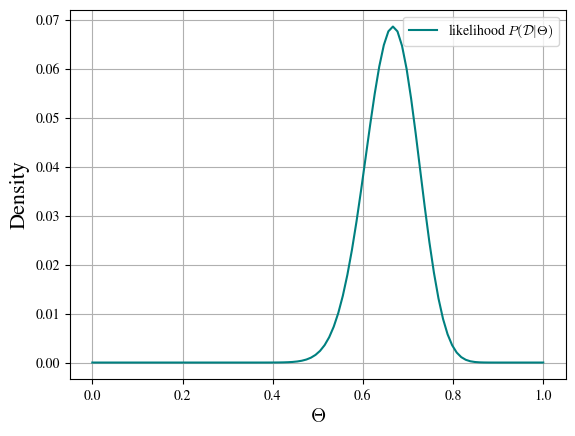

In [63]:
# @title: ##MLE interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 63 #@param {type:"slider", min:1, max:100, step:1}
h = 19 #@param {type:"slider", min:0, max:100, step:1}

# compute likelihood at each point in the grid


# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal',label='likelihood $P(\mathcal{D}|\Theta)$')
ax.legend()
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.grid(0.3)
plt.show()

**Group coding task 10**: Now let's add the MLE. See if you can code it and then test it in the code that follows!

In [ ]:
def mle(H=h,N=n):
  p_mle = ## put your code here! write this in terms of the number of heads (H) and total flips (N)
  return p_mle

SyntaxError: ignored

##### Run the below to test your answer!

In [ ]:
def mle_true(pmle=mle()):
  correct = False
  if jnp.round(pmle,1) == jnp.round(h/n,1):
    correct = True
  return correct

if mle_true() == True:
  print('Correct!')
else:
  print('Hmm, not quite... Note that we round at the first decimal!')

Hmm, not quite... Note that we round at the first decimal!


##### Now let's add the MLE to our sliders

In [88]:
# answer to MLE
def mle(H=h, N=n):
  p_mle = H/N
  return p_mle

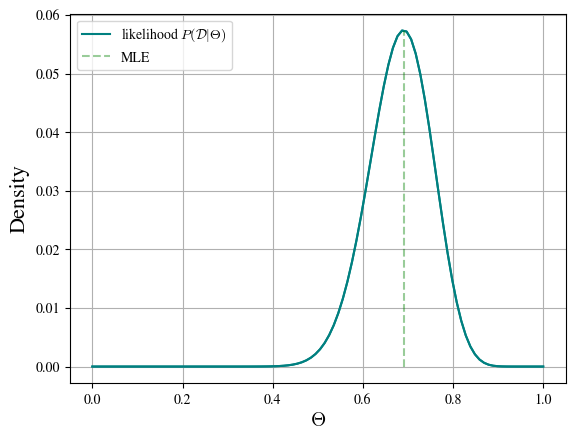

In [71]:
# @title: ##MLE interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 42 #@param {type:"slider", min:1, max:100, step:1}
h = 29 #@param {type:"slider", min:0, max:100, step:1}

# compute likelihood at each point in the grid


# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

p_mle = mle(H=h,N=n)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal')
ax.plot(p_grid, likelihood,color='teal',label='likelihood $P(\mathcal{D}|\Theta)$')
ax.vlines(p_mle,0,max(likelihood),color='green',label='MLE',linestyle='--',alpha=0.4)
ax.legend()
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.grid(0.3)
plt.show()

#### Problems with MLE

MLE seems to be a straightforward and intuitive approach, but it has a few problems. 😮
* It doesn't take into account the amount of data we have fed it.
* There is no notion of uncertainty.
* MLE is prone to overfitting because it may perfectly fit the empirical data we give it, but not predict well on future data.

**Group task 11**: For example, let's consider the case in which we take 4 trials and see 4 heads consecutively. Using the sliders and derived formula above, calculate the MLE for the parameters in this situation. How likely do you think it is that this reflects the truth? What is the probability that we just happened to get 4 heads in a row for a balanced coin (i.e. where we make the prior assumption that $\theta = 0.5$)?

Play with the sliders and see how things change as the number of samples increase: would you be more or less confident in your answer for the MLE with a much larger number of trials?

##### Answer to group task B11

If you use the formula or sliders, you should get $\theta_{MLE}=1$ - which means we are certain we will continue to get heads! That seems a bit odd, since the probability of 4 heads in a row for a balanced coin is $\frac{1}{16}$ (assuming order matters). This is also called **overfitting**, since we have a MLE estimate that perfectly works on the data we have available (which you could think of as training data) but probably does not generalise to prediciton on test data. Intuitively, you should be happier with the MLE as the number of data points grows: but there isn't anything inherently in the MLE procedure that can tell you that degree of confidence or uncertainty!

We would like to be able to take a prior/weighting into consideration, which motivates the next section: MAP estimates!

#### [Optional] MLE is minimising KLD [<font color='red'>`Advanced`</font>]


It turns out that minimising the KL divergence is the same as maximising the <font color='teal'>`likelihood`</font> estimate!

\begin{equation*}
\arg \min_\theta D_{KL} (p(x \vert \theta^*) \vert\vert p(x \vert \theta)) = \arg \max_\theta p(\mathcal{D} \vert \theta)
\end{equation*}

Let's walk through the proof.

Remember that when $p$ is the underlying distribution, minimising the KL divergence means finding optimal parameters $\theta$ for distribution (or model) $q$ so that $\mathbb{E}_{x \sim p} \big[ \log \frac{p(x \vert \theta^*)}{p(x \vert \theta)} \big]$ is minimal. Here, $\theta^*$ are the optimal parameters (that we don't know) and $\theta$ the parameters we are trying to find. Since we don't ever know $\theta^*$ we will write $p(x)$ instead of $p(x \vert \theta)$ below (don't let it trick you up!).

Often in Bayesian inference, $p(x \vert \theta)$ is written as $q(x \vert \theta)$ where $q$ is the inferred distribution.

**Exercise**: See if you can think how to simplify this equation into terms containing just $\theta$.

##### Answer:

\begin{eqnarray*}
\arg \min_\theta D_{KL}(p \vert \vert p(x \vert \theta) &=& \arg \min_\theta \mathbb{E}_{x \sim p} \bigg[ \log \frac{p(x)}{p(x \vert \theta)} \bigg] \\
&=& \arg \min_\theta \mathbb{E}_{x \sim p} \big[ \log p(x) - \log p(x \vert \theta) \big] \\
&=& \arg \min_\theta - \mathbb{E}_{x \sim p} \big[ \log p(x \vert \theta) \big] \\
\end{eqnarray*}

Since $p(x \vert \theta^*)$ is not dependent on $\theta$.

##### Optimisation on the min KLD problem

Note that we can always flip a minimisation into a maximisation using a negative sign:

\begin{equation*}
\arg \min_\theta \Big[- \mathbb{E}_{x \sim p} \big[ \log p(x \vert \theta) \big]\Big] = \arg \max_\theta \mathbb{E}_{x \sim p} \big[ \log p(x \vert \theta) \big]
\end{equation*} \\

And here's a tricky bit that you may not of seen: we need to use the definition of expectation and the law of large numbers to write out the expectation in terms of some $x_i$ drawn from the distribution $p$.

**Exercise**: See if you can complete the rest of the proof using this knowledge. 😸

##### Answer:

\begin{eqnarray*}
 \arg \max_\theta \mathbb{E}_{x \sim p} \big[ \log p(x \vert \theta) \big] &=& \arg \max_\theta \lim_{n \rightarrow \infty} \sum_{i=1}^n \log(p(x_i \vert \theta)) \\
 &=& \arg\max_\theta \log P(x\vert \theta) \\
 &=& \arg \max_\theta P(\mathcal{D} \vert \theta) \\
 &=& \hat{\theta}_{MLE}
\end{eqnarray*}

As we wished to show!

### Regularisation and maximum a posterior estimation


We can try to eliminate some overfitting through adding a penalty term to the NLL (this is known as regularisation ⤴):

\begin{equation*}
\mathcal{L}(\theta; \lambda) = NLL  - \lambda C(\theta)
\end{equation*}

Commonly, we use $C = p(\theta)$, where $p(\theta)$ is the <font color='purple'>`prior`</font> for $\theta$. If $\lambda = 1$,

\begin{eqnarray*}
\hat{\theta} &=& \arg \min_\theta -\big[\log p(\mathcal{D\vert \theta}) + 1\cdot \log p(\theta)\big]\\
&=& \arg \max_\theta \big[\log p(\mathcal{D\vert \theta}) + \log p(\theta)\big] \\
& =& \arg\max_\theta \log \big[p(\mathcal{D\vert \theta})p(\theta)\big] \\
&=& \arg\max_\theta \log p(\theta \vert \mathcal{D})
\end{eqnarray*}

This is the same as _maximising the log posterior_ -- hence, **<font color='violet'>`maximum a posterior estimation`</font>** (MAP)! 🥳

### Coin flips: the Bayesian way

Let's apply this to the Bernoulli coin flip example. 💰 We'll use a beta distribution for the <font color='purple'>`prior`</font>, $p(\theta) = \text{Beta}(\theta \vert a,b)$:

\begin{equation*}
p(\theta \vert a,b) = \text{Beta} (\theta \vert a,b) = \frac{\theta^{a-1}(1-\theta)^{b-1}}{\beta(a,b)}
\end{equation*}

Note that the <font color='violet'>`maximum a posterior (MAP)`</font> estimate is still a point estimate -- it just takes into account our belief about the <font color='purple'>`prior`</font> distribution.

*If you need a refresher on beta distributions, check back to the probability distribution section!*

**Group task 12**: By hand, calculate the MAP estimate with a beta prior.

#### Hint

Start with $\mathcal{L}(\theta) = \log P(\mathcal{D}\vert \theta)+\log P(\theta)$ and recall that we have already calculated $\log P(\mathcal{D}\vert\theta)$ in the MLE section - is it is the negative of the negative log likelihood!

Then, optimise (take derivatives in terms of $\theta$ and set to 0).

_Note: Can you see why the negative log likelihood vs "positive" log likelihood will give you the same answer when optimising? Remember than optimisation depends on when the derivative is 0, but cannot distinguish maxima vs minima without additional tests! Minimising the $NLL$ is the same as maximising the log likelihood because logarithms are concave functions!_


#### Answer to group task B12

Note that $\beta(a,b)$ does not depend on $\theta$ (is a constant), so it drops out of any max/min calculations. Taking the derivative of the log likelihood and setting to 0:

\begin{eqnarray*}
\mathcal{L}(\theta) &=& \log p(\mathcal{D}\vert \theta)\log P(\theta) \\
&=& \big[ N_1 \log \theta + N_0 \log (1-\theta)\big] + \big[(a-1)\log\theta+(b-1)\log(1-\theta)\big] \\
\implies 0 &=& \frac{d}{d\theta} \big[ N_1 \log \theta + N_0 \log (1-\theta)\big] + \big[(a-1)\log\theta+(b-1)\log(1-\theta)\big] \\
\implies 0 &=& \frac{N_1 + a-1}{\theta} - \frac{N_0+b-1}{ (1-\theta)} \\
\end{eqnarray*}

Lastly, rearranging and solving for $\theta$:
\begin{equation*}
\implies \theta_{MAP} = \frac{N_1 + a -1}{N_1 + N_0 + a +b -2}
\end{equation*}

Excellent job if you managed to get this derivation! 🤯

#### Interactive exercise: making sense of the MAP estimate

The MAP derivation may not immediately make as much sense as the MLE. To get some intuition, let's implement the <font color='violet'>`maximum a posterior (MAP)`</font> estimate in code!

**Group coding task 13**: Play with the sliders to see how the posterior is formed, then implement your MAP estimate in the code block below. How does it compare to the MLE?

_Note: For those with beady eyes who saw that the posterior here takes a certain form, we'll explain why in a second!_ 👀

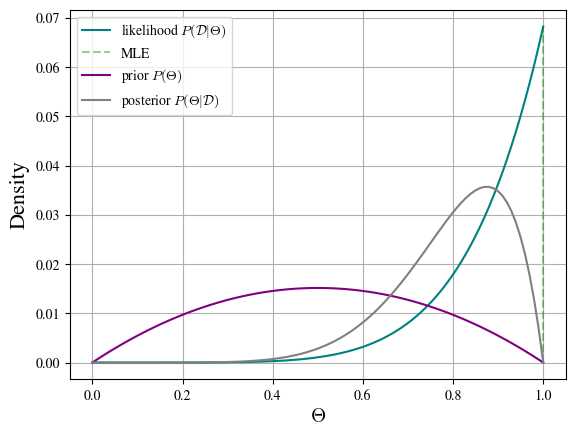

In [90]:
# @title: ##MAP interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
# alpha, beta hyperparams for the Beta distribution
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 6 #@param {type:"slider", min:1, max:100, step:1}
h = 6 #@param {type:"slider", min:0, max:100, step:1}
alpha = 2 #@param {type:"slider", min:0, max:10, step:1}
beta = 2 #@param {type:"slider", min:0, max:10, step:1}

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

# Bayesian
# prior, then normalise
log_prob_prior = dist.Beta(alpha,beta).log_prob(p_grid)
prior = jnp.exp(log_prob_prior - jnp.max(log_prob_prior)) / jnp.sum(jnp.exp(log_prob_prior - jnp.max(log_prob_prior)))
# posterior, then normalise
log_prob_post = dist.Beta(alpha+h,beta+n-h).log_prob(p_grid)
post = jnp.exp(log_prob_post - jnp.max(log_prob_post)) / jnp.sum(jnp.exp(log_prob_post - jnp.max(log_prob_post)))

# plotting
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal',label='likelihood $P(\mathcal{D}|\Theta)$')
ax.vlines(mle(H=h,N=n),0,max(likelihood),color='green',label='MLE',linestyle='--',alpha=0.4)
ax.plot(p_grid, prior, label='prior $P(\Theta)$', c='purple')
ax.plot(p_grid, post, label='posterior $P(\Theta | \mathcal{D})$', c='gray')
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.legend()
ax.grid(0.3)
plt.show()

**Group coding task 13 continued**: Now let's add the MAP estimate. See if you can code it and then test it in the code that follows!

In [ ]:
def map(H=h,N=n,a=alpha,b=beta):
  p_map = 0## put your code here! write this in terms of the number of heads (H) and total flips (N)
  return p_map

##### Run the below to test your answer!

In [ ]:
def map_true(pmap=map()):
  correct = False
  if jnp.round(pmap,1) == jnp.round((h+alpha-1)/(n+alpha+beta-2),1):
    correct = True
  return correct

if map_true() == True:
  print('Correct!')
else:
  print('Hmm, not quite... Note that we round at the first decimal!')

Hmm, not quite... Note that we round at the first decimal!


##### Answer to group task B13

In [85]:
def map(H=h,N=n,a=alpha,b=beta):
  p_map = (h+alpha-1)/(n+alpha+beta-2) ## put your code here! write this in terms of the number of heads (H) and total flips (N)
  return p_map

 ##### Finally, have a look at the sliders with the MAP estimate included.

 Play with the parameters and see what happens when you replicate the case for which there are 4 heads in a row and 4 trials. Does the answer make more sense? What do $\alpha$ and $\beta$ do?



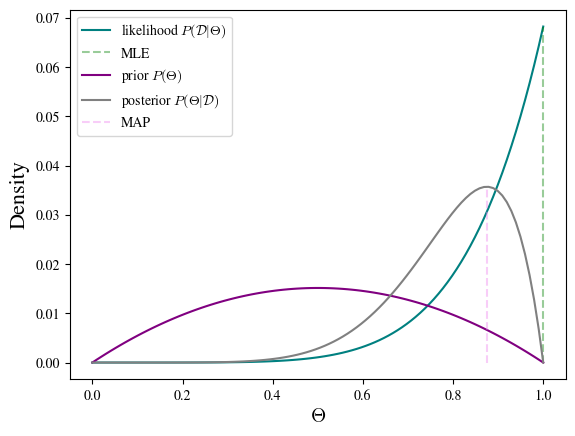

In [94]:
# @title: ##MAP interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
# alpha, beta hyperparams for the Beta distribution
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 6 #@param {type:"slider", min:1, max:100, step:1}
h = 6 #@param {type:"slider", min:0, max:100, step:1}
alpha = 2 #@param {type:"slider", min:0, max:10, step:1}
beta = 2 #@param {type:"slider", min:0, max:10, step:1}

# compute likelihood at each point in the grid
likelihood = stats.binom.pmf(h, n, p_grid)/jnp.sum(stats.binom.pmf(h, n, p_grid))

# Bayesian
# prior, then normalise
log_prob_prior = dist.Beta(alpha,beta).log_prob(p_grid)
prior = jnp.exp(log_prob_prior - jnp.max(log_prob_prior)) / jnp.sum(jnp.exp(log_prob_prior - jnp.max(log_prob_prior)))
# posterior, then normalise
log_prob_post = dist.Beta(alpha+h,beta+n-h).log_prob(p_grid)
post = jnp.exp(log_prob_post - jnp.max(log_prob_post)) / jnp.sum(jnp.exp(log_prob_post - jnp.max(log_prob_post)))

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal',label='likelihood $P(\mathcal{D}|\Theta)$')
ax.vlines(mle(H=h,N=n),0,max(likelihood),color='green',label='MLE',linestyle='--',alpha=0.4)
ax.plot(p_grid, prior, label='prior $P(\Theta)$', c='purple')
ax.plot(p_grid, post, label='posterior $P(\Theta | \mathcal{D})$', c='gray')
ax.vlines(map(H=h,N=n,a=alpha,b=beta),0,max(post), color='violet', linestyle='dashed', alpha=0.4, label='MAP')
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.legend()
plt.show()

### To go a little further: conjugate <font color='purple'>`priors`</font>

Note that in the coin flipping example, plotting the distributions is easy because we can actually compute the full <font color='gray'>`posterior`</font> analytically:

\begin{eqnarray*}
p(\theta \vert H) &=& \frac{p(\theta)p(H\vert \theta)}{p(H)} \\
&=& \frac{\text{Beta}(\theta \vert a,b)\cdot \theta}{p(H)} \\ & \propto& \theta \cdot \text{Beta}(\theta \vert a,b) \\
& \propto & \theta \cdot \theta^{a-1}(1-\theta)^{b-1} = \text{Beta}(\theta \vert a +1, b)
\end{eqnarray*}

We get another Beta distribution, which we can manipulate and compute easily and exactly! And these allow $\alpha$ and $\beta$ to be interpretable in terms of what we we expect (<font color='purple'>`prior`</font> knowledge) about the number of heads and tails.

This is because we used a <font color='purple'>`prior`</font> from the exponential family, and this prior is known as a **<font color='purple'>`conjugate prior`</font>**. Conjugate priors are particularly useful because they allow us to ensure tractable <font color='gray'>`posteriors`</font>, that is posterior distributions that we can compute and work with easily.

_Note: This practical doesn't cover conjugacy and the exponential family in depth, but you should ask your tutor if you want to find out more!_ 😸

### Analytical derivation of multivariate Gaussian-Gaussian posterior, and sampling

Conjugacy is really useful and neat... When it works! There are lots of times when you won't be able to fit a conjugate prior, as you will see later. There are also lots of times when finding the analytical expression for a conjugate prior's posterior involves pages of maths. For example, check out this derivation of a multivariate Gaussian posterior from a Gaussian conjugate prior and Gaussian likelihood: [Conjugate Analysis for the Multivariate Gaussian](https://https://gregorygundersen.com/blog/2020/11/18/bayesian-mvn/).

And this is considered one of the easier examples... Yikes! 😨

**Group task 14**: If we can't find an analytical solution for the posterior, think about ways we could still approximate the distribution.


#### Sampling

We want ways to work with probabilistic derivations and Bayesian inference/point estimates when we can't find a conjugate posterior.

For this, we move to sampling! This means, considering a distribution that we don't know the exact form of mathematically, but from which we *can simulate many samples*, and taking those samples to in turn "construct" some property... Almost like how one would make a histogram of data. 📊 To start off, you'll see the famous Monte Carlo method. 🙌

### [Optional] Comparing models using MAP [likely drop this?]

You should probably have noticed that the MAP estimate is very much biased by the prior that we choose. So, how do we know which model of the prior is the best one? Well, we can just use Bayes' Rule again!

After seeing some data, let's decide which model (bent or fair) best fits. We can just directly compare the **evidence** for a model given by
\begin{equation*}
P(\mathcal{D} \vert \mathcal{M}) = \int P(\mathcal{D} \vert \theta_M) P(\theta_M \vert \mathcal{M}) d\theta_M
\end{equation*}

## The Monte Carlo method [<font color='orange'>`Intermediate`</font>]

The Monte Carlo method is a computational technique that uses **<font color='teal'>`random sampling`</font>** to estimate complex mathematical outcomes or solve problems that might be **<font color='teal'>`deterministic`</font>** in nature.

### Monte Carlo integration

Let us consider the example of computing of an integral of a function. This is a deterministic problem, but we will solve it using random sampling.

**Problem to solve:** find value of the integral

$$\int_a^b f(x)dx. $$

Monte Carlo integration estimates this integral by finding the fraction of random points that fall below $f(x)$.

In the **Bayesian inference** context, we are usually interested in estimating expectations (which are themselves point estimates):

$$ E[h(x)] = \int h(x)f(x)dx,$$

which can be done with

$$ \bar{h}_n = \frac{1}{n} \sum_i^n h(x_i),$$
where $x_i ∼ f$ is a draw from the density $f$.

**Exercise:** _Do you see how this is **sampling** to figure out a property?_

The convergence of Monte Carlo integration is $\mathcal{O}(n^{1/2})$ and is independent of the dimensionality. Hence, Monte Carlo integration **generally** beats numerical intergration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $0(n^d)$!

### Monte Carlo integration - Example

Estimate the integral $\int_0^1 e^x dx$ using Monte Carlo integration.

1.7182817
        10 1.902797
       100 1.522238
      1000 1.693490
     10000 1.714692
    100000 1.712083
   1000000 1.719362
  10000000 1.717446
 100000000 1.718108


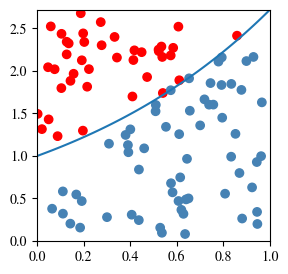

In [ ]:
##############################################
# the Monte Carlo method - integration
##############################################

print(jnp.exp(1) - jnp.exp(0))

plt.figure(figsize=(3, 3))

x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= jnp.e

cols = ['steelblue'] * 100
for i in range(100):
    if pts[i,1] > jnp.exp(pts[i,0]):     # acceptance / rejection step
        cols[i] = 'red'


plt.scatter(pts[:, 0], pts[:, 1], c = cols)
plt.xlim([0,1])
plt.ylim([0, jnp.e]);

# Monte Carlo approximation

for n in 10**np.array([1,2,3,4,5,6,7,8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= jnp.e
    count = jnp.sum(pts[:, 1] < jnp.exp(pts[:, 0]))
    volume = jnp.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))

## Markov Chain Monte Carlo (MCMC)

We want to estiamte the posterior distribution, but this is often intractable.

MCMC is a computational technique used to approximate complex probability distributions by generating a **<font color='teal'>`sequence of (correlated) samples`</font>**, where each sample is obtained by iteratively transitioning through a Markov chain with carefully designed transition probabilities.


### How does MCMC work (very rough overview)?

- Draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain).
- Under certain conditions, the Markov chain will have a unique stationary distribution.

- We set up an acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution we are searching for.

- There is no need to evaluate the potentially intractable marginal likelihood.

- After sufficient number of iterations, the Markov chain of accepted draws will converge to the staionary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution.

The next optional section demonstrates an example of **<font color='teal'>`Matrolopolis-Hastings`</font>** algorithm - this is an example of MCMC.

## [Optional] Metropolis-Hastings random walk algorithm

- Start with an initial guess for $\theta$

- Chose a new proposed value as $\theta_p = \theta + \delta_\theta, \delta_\theta \sim N(0, \sigma).$
   
  Here we have chosen the proposal distribution to be $N(0, \sigma).$
  
- If $g$ is the posterior probability, calculate the ratio $\rho = \frac{g(\theta_p \mid X)}{g(\theta \mid X)}$

- (adjust for symmetry of the proposal distribution)


- If $\rho \ge 1,$ accept $\theta = \theta_p;$ if $\rho < 1,$ accept  $\theta = \theta_p$ with probability $p,$ otherwise keep $\theta = \theta.$ (This step is done with the help of the standard Uniform distribution)

In [ ]:
##############################################
# Metropolis-Hastings
##############################################

Portion of accepted steps = 0.1869


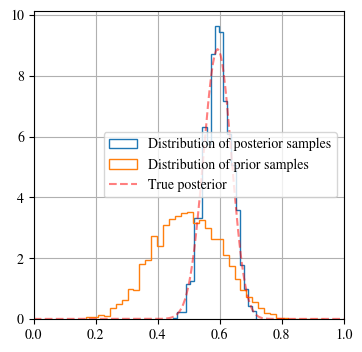

In [ ]:
def target(likelihood, prior, n, h, theta):
    """
    define target distribution
    """
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(n, theta).pmf(h)*prior.pdf(theta)


# number of experiments
n = 100

# number of successes
h = 61

# hyperparameters for the prior
a = 10
b = 10
likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

# initilisation
naccept = 0
theta = 0.1

# set the number of MCMC iterations
niters = 10000

# run MH
samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta

# analyse MH output
nmcmc = len(samples)//2
print("Portion of accepted steps = " + str(naccept/niters))

post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(4, 4))
plt.hist(samples[nmcmc:], 20, histtype='step', linewidth=1, label='Distribution of posterior samples', density =True);
plt.hist(prior.rvs(nmcmc), 40, histtype='step',  linewidth=1, label='Distribution of prior samples', density=True);
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.grid(0.3)
plt.legend(loc='best');

We run the chain for $N$ iterations and discard the first $B$ samples. This is called **<font color='purple'>`burn-in`</font>** (or "warm-up").

We can run several parallel versions of the algorithm. Each of them is called a **<font color='green'>`chain`</font>**.

Neigbouring samples will contain similar information. We might want to save only every second, or fifth, or tenth. This is called **<font color='orange'>`thinning`</font>**.

## Convergence diagnostics

Rigorous way of assesing convergence is an unsolved problems. But there are several tool swe can use to convice ourselves that an MCMC has converged, such as

- trace plots need to look stationary
- parallel chains should carry similar information

In [ ]:
## Convergence diagnostics

def mh_coin(niters, n, h, theta, likelihood, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)

    return samples

In [ ]:

n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

chains = [mh_coin(niters, n, h, theta, likelihood, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

In [ ]:
# compare multiple chains

plt.figure(figsize=(5, 4))

for chain in chains:
    plt.plot(chain, '-o')

plt.xlim([0, niters])
plt.ylim([0, 1]);

Was it very painful to write a sampler by hand?

If not, bare in mind that we only wrote the simplest one possible! Sampling algorithms can get very complicated. 🧠

#Part C: Probabilistic programming [<font color='orange'>`Intermediate`</font>]


[Probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming) is a paradigm in computer programming that enables the creation of models and algorithms capable of <font color='green'>handling uncertainty</font> and randomness. It combines principles from probability theory and programming to build systems that can reason about uncertain data and make informed decisions. This approach allows developers to express complex models in a natural and intuitive way, enabling tasks such as Bayesian inference, machine learning, and statistical analysis to be performed more effectively.

In this section we will give an overview of the modern landscape of <font color='orange'>probabilistic programming languages (PPLs)</font>, and demonstrate abilities of one of them (NumPyro).

Familiarity with a PPL will equip participants with a tool allowing them to <font color='green'>focus on the scientific problem</font> of interest, while inference is being taken care of by the inference engine. We will show how to use the [NumPyro](https://num.pyro.ai/en/latest/index.html#) library to perform exact Bayesian inference (using Markov Chain Monte Carlo).

## Probabilistic programming languages (PPLs)

Luckily, we do not need to write a sampler by hand every time, because PPLs are there to help.

A PPL allows to formalize a Bayesian model and perform inference with the help of powerful algorithms. **<font color='teal'>A user needs to only formulate the model</font>**. And maybe chose a sampler.

## [Optional] Historical overview of PPLs

### <font color='blue'>1st generation: Bugs, WinBugs, Jags, etc.</font>

- Inference engine based on Monte Carlo methods.

- They did not scale to large data samples/high-dimensional models.

###  <font color='blue'>2nd generation: Infer.net, Factorie, Amidst, etc.</font>

- Inference engine based on message passage algorithms and/or variational
inference methods.

- They did scale to large data samples/high-dimensional models.

- Restricted probabilistic model family (i.e. factor graphs, conjuage exponential family, etc.)

### <font color='blue'>3rd generation: Stan, TensorFlow Probability, PyMC3, Pyro, Numpyro, Turing.jl, NIMBLE, Edward, InferPy, etc.</font>

- Hamiltonian Monte-Carlo, Black Box Variational Inference, etc.

- They did scale to large data samples/high-dimensional models.

- Enable probabilistic models with deep neural networks:
  - Rely on deep learning frameworks (TensorFlow, Pytorch, Theano, etc).
  - Specialized hardware like GPUs, TPUs, etc.
  - Automatic differentiation methods.

## Introduction to NumPyro [<font color='orange'>`Intermediate`</font>]

[NumPyro](https://num.pyro.ai/en/stable/index.html) is a probabilistic programming library that provides a <font color='green'>`NumPy`</font> backend for <font color='green'>`Pyro`</font>. It relies on <font color='green'>`JAX`</font> for automatic differentiation and JIT compilation to GPU / CPU.

NumPyro provides access to a wide range of [probability distributions](https://num.pyro.ai/en/latest/distributions.html).

There is a choice of samplers which one can use to perform inference with NumPyro, with particular focus on **MCMC** algorithms.

### NumPyro two-minutes introduction

- parameters can be sampled using  <font color='green'>`numpyro.sample`</font>
- parameters can be sampled from any of the available distrinutsions using, e.g.  <font color='green'>`dist.Beta(alpha, beta)`</font> (same as what you've learnt above)
- likelihood is constructed by adding `obs=...` to the sampling statement: <font color='green'>`numpyro.sample('obs', dist.Binomial(n, p), obs=h)`</font>
- once the model has been formulated, we need to specify
 - the sampling algirothm which we would like to use. NUTS is a good default oprtion: <font color='green'>`kernel = NUTS(model)` </font>
 - number of warm-up steps, number of iterations, number of chains, e.g. <font color='green'>`MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)`</font>
 - using <font color='green'>`Predictive` </font> class we can generate predictions.

 Let's see how it works in practice!

### Coin example tossing with NumPyro

In [ ]:
# double-check that all necessary installations are in place
import numpyro
import numpyro.distributions as dist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

In [ ]:
n = 100    # number of trials
h = 61     # number of successes
alpha = 2  # hyperparameters
beta = 2

niter = 1000

### Model

In [ ]:
def model(n, alpha=2, beta=2, h=None):

    # prior
    p = numpyro.sample('p', dist.Beta(alpha, beta))

    # likelihood - notice the `obs=h` part
    numpyro.sample('obs', dist.Binomial(n, p), obs=h)

### Prior predictive check

A <font color='purple'>prior predictive check</font> is a method used in Bayesian statistics to assess the <font color='orange'>compatibility of a chosen prior distribution</font> with the observed data by simulating data from the prior and comparing it to the actual data - an overlooked but golden tool!

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# use the Predictive class to generate predictions.
# Notice that we are not passing observation `h`
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, n)

In [ ]:
# we have generated samples for two variables
prior_predictions.keys()

dict_keys(['obs', 'p'])

In [ ]:
# extract samples for variable 'p'
pred_obs = prior_predictions['p']

# compute its summary statistics for the samples of `p`
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

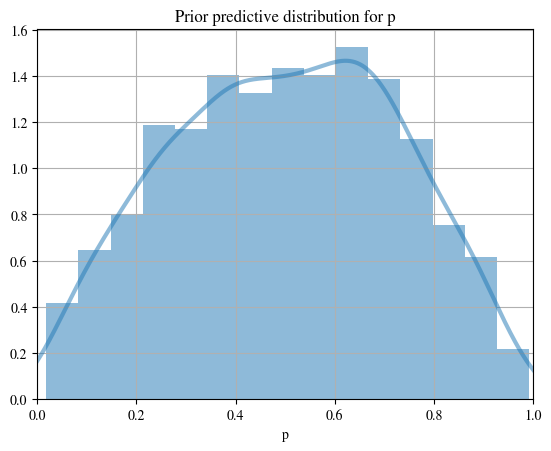

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(pred_obs, bins=15, density=True, alpha=0.5)
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('p')
ax.set_title('Prior predictive distribution for p')
ax.set_xlim(0, 1)
ax.grid(0.3)
plt.show()

### Inference

Using the same routine as we did for prior redictive, we can perform inference by using the observed data.

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# specify inference algorithm
kernel = NUTS(model)

# define number of samples and number chains
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)

<ipython-input-28-87b818fc0d20>:8: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)


In [ ]:
#run MCMC
mcmc.run(rng_key_, n=n, h=h)

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2812.50it/s, 3 steps of size 9.60e-01. acc. prob=0.93]


In [ ]:
# inpect summary
# r_hat is an importnat convergene diagnostoc, we want it to be close to 1
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.61      0.05      0.61      0.53      0.69   3084.07      1.00

Number of divergences: 0


In [ ]:
# exatract samples of parameter p
p_samples = mcmc.get_samples()
p_posterior_samples = p_samples['p']

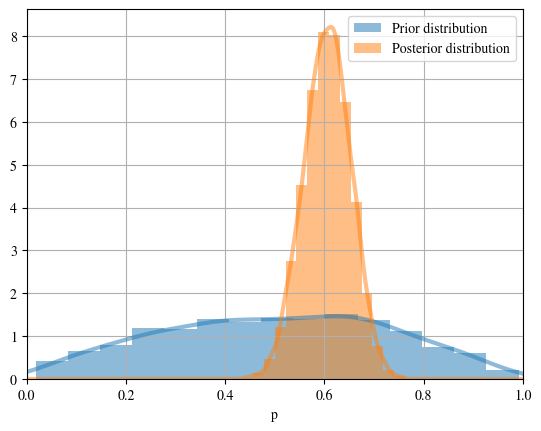

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(pred_obs, bins=15, density=True, alpha=0.5, label = "Prior distribution")
ax.hist(p_posterior_samples, bins=15, density=True, alpha=0.5, label = "Posterior distribution")
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
kde = gaussian_kde(p_posterior_samples)
ax.plot(x, kde(x), color='C1', lw=3, alpha=0.5)
ax.set_xlabel('p')
ax.set_xlim(0, 1)
ax.grid(0.3)
plt.legend()
plt.show()

### Check convergence

How can we assess whether we can trust the results? Convergence diganostics!

In [ ]:
import arviz as az

In [ ]:
# pring summary and ook at R-hat
mcmc.print_summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.61      0.05      0.61      0.53      0.69   3084.07      1.00

Number of divergences: 0


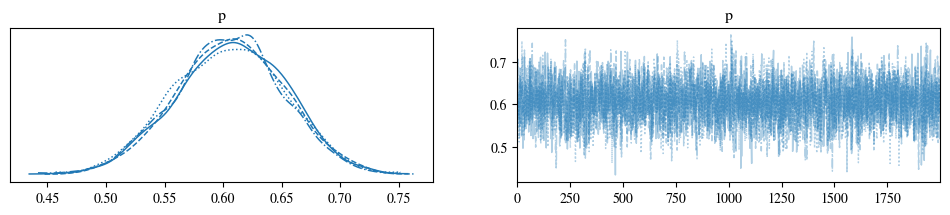

In [ ]:
# plot traceplots
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### Posterior predicitve

The <font color='purple'>posterior predictive</font> distribution is a concept in Bayesian statistics that combines the information from both the observed data and the posterior distribution of model parameters to <font color='orange'>generate predictions for new, unseen data</font> .

We can use the obtained samples obtained at the previous step to generate posterior predictive desitribution on the outcome.

In [ ]:
# using the same 'Predictive' class,
# but now specifying also `p_samples`
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, p_samples)
posterior_predictions = predictive(rng_key_, n=n)


In [ ]:
# extract prediction and calculate summary statistics
post_obs = posterior_predictions['obs']
mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

In [ ]:
# what is the mean number of successes?
mean_post_pred

Array(60.54975, dtype=float32)

In [ ]:
# what is the unceratinty around this mean?
hpdi_post_pred

array([49, 71], dtype=int32)

**Group task NN:** change hyperparamaters of the model. How are they changing the results?

## Bayesian Linear regression

Now we know how to use NumPyro. Let us build an example using larger amounts of data and buil a Bayeisan Linear Regression model. It the same Linear Regression model as you are familiar with, but here all of the parameters are estinated in the Bayesian way.

### [TO DO]: fix data import from GitHub repo

In [ ]:
#import pandas as pd
#import urllib.request

## Download the data file
#url = "https://github.com/elizavetasemenova/indaba-pracs-2023/blob/intro-to-probability/data/Howell1.csv"
#filename = "Howell.csv"
#urllib.request.urlretrieve(url, filename)

## Load data into a DataFrame
#df = pd.read_csv(filename)

## Display the first few rows of the DataFrame
#print(df.head())

In [ ]:
#!wget https://github.com/elizavetasemenova/indaba-pracs-2023/blob/intro-to-probability/data/Howell1.csv
#df = pd.read_csv('Howell1.csv')
#df.head()

In [ ]:
# load the data

from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv('drive/MyDrive/Howell1.csv', sep=";")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
# observed data
weight = df.weight.values
height = df.height.values

# data to make predictions for
weight_pred = np.array([45, 40, 65, 31, 53])

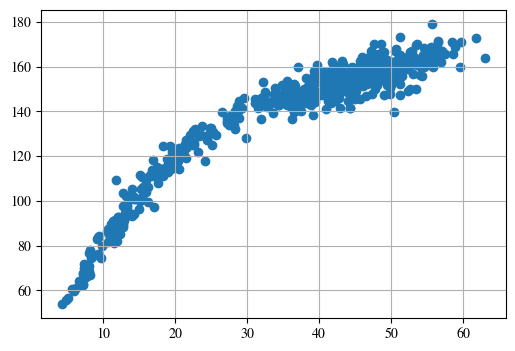

In [ ]:
# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x='weight', y='height', data=df)
plt.grid(0.3)

In [ ]:
# model

def model(weight=None, height=None):

    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # deterministic transformation
    mu = b0 + b1 * weight

    # likelihood: notice `obs=height`
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

In [ ]:
# prior predictive

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)

In [ ]:
prior_predictions.keys()

dict_keys(['b0', 'b1', 'obs', 'sigma'])

In [ ]:
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

In [ ]:
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean)
    ax.plot(weight, ht, 'o')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

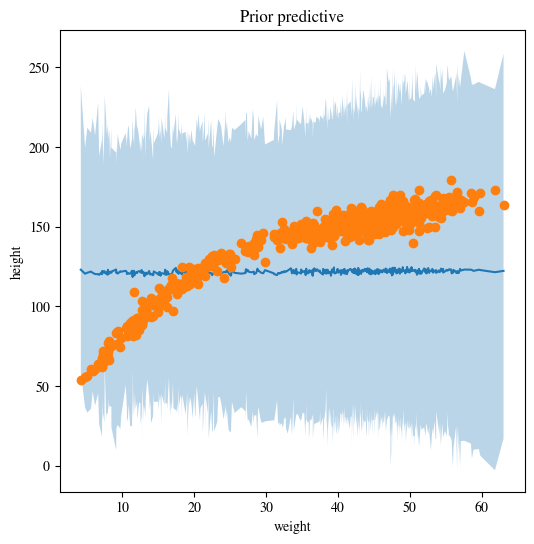

In [ ]:
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

In [ ]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

<ipython-input-63-3133be85c61d>:8: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1526.27it/s, 15 steps of size 2.61e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     75.50      1.06     75.49     73.66     77.16   2695.31      1.00
        b1      1.76      0.03      1.76      1.72      1.81   2722.23      1.00
     sigma      9.37      0.29      9.37      8.89      9.83   3861.06      1.00

Number of divergences: 0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     75.50      1.06     75.49     73.66     77.16   2695.31      1.00
        b1      1.76      0.03      1.76      1.72      1.81   2722.23      1.00
     sigma      9.37      0.29      9.37      8.89      9.83   3861.06      1.00

Number of divergences: 0


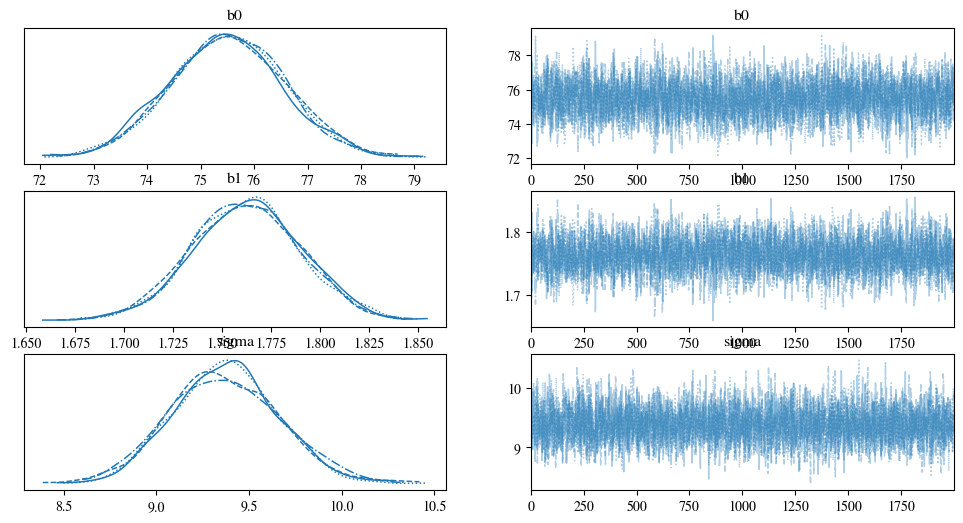

In [ ]:
# Check convergence

mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

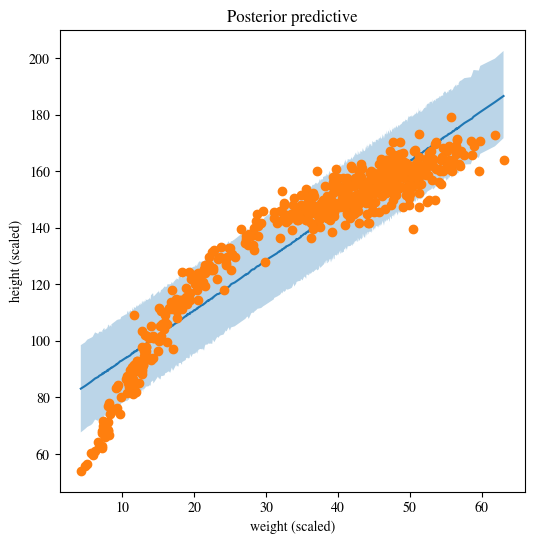

In [ ]:
# Posterior predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

In [ ]:
# predict for new data

predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, weight=weight_pred)['obs']

mean_pred = np.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'weight_pred': weight_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_res = pd.DataFrame(data=d)
df_res.head()

,weight_pred,mean_pred,lower,upper
0,45,154.771286,139.118423,169.388168
1,40,146.173187,130.664017,160.518707
2,65,190.039124,175.580215,205.185654
3,31,130.221878,115.789368,145.743134
4,53,168.715240,152.795578,182.871323


**Group task NN:** modify the model in a way that it fits better.

**Hint:** apply a transformations to input data, e.g. a polynomial.

In [ ]:
def model_polyn_2(weight, height=None):

    weight_std = (weight - np.mean(weight))/np.std(weight)
    weight_std_2 = weight_std ** 2

    # priors
    b0 = numpyro.sample('b0', dist.Normal(160,20))
    b1 = numpyro.sample('b1', dist.Normal(0,5))
    b2 = numpyro.sample('b2', dist.Normal(0,5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(50.))

    mu = b0 + b1 * weight_std + b2 * weight_std_2

    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

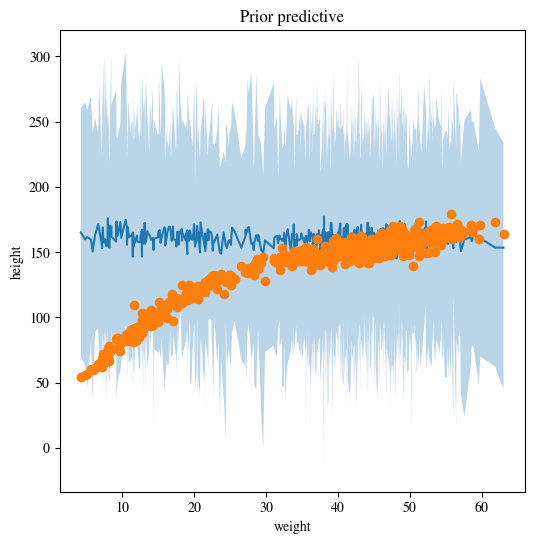

In [ ]:
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model_polyn_2, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight=weight)
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

In [ ]:
# inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_polyn_2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_3= mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:10<00:00, 283.57it/s, 7 steps of size 5.33e-01. acc. prob=0.91]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    146.67      0.38    146.66    146.02    147.29   1028.17      1.00
        b1     21.34      0.30     21.35     20.82     21.80   1092.92      1.00
        b2     -8.40      0.29     -8.40     -8.85     -7.91    966.79      1.00
     sigma      5.77      0.17      5.76      5.49      6.03   1636.49      1.00

Number of divergences: 0


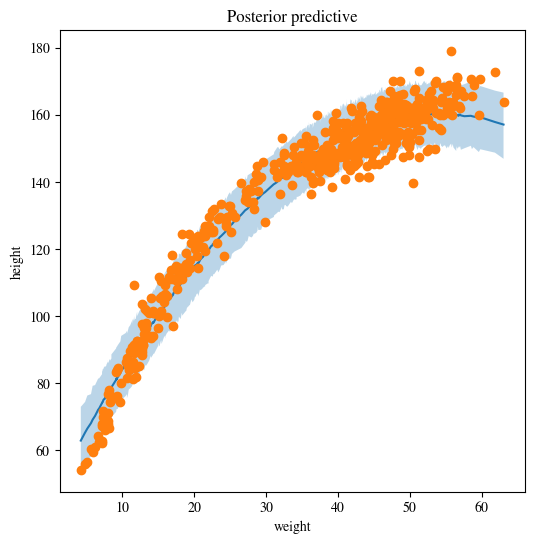

In [ ]:
# posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_polyn_2, samples_3)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']
mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight', ylabel='height');

## [Optional] The Monte Carlo method - [<font color='orange'>`Intermediate`</font>]

[Kira suggestion -- move this down, collapse all of coin tossing into one section with compute by hand + coding...]

is a group of algorithms which use random sampling repeatedly to make numerical estimations of unknown qunatities/parameters (originated within the Manhattan Project thanks to Stanislaw Ulam).

Let us tacke the following problem:

Find approximate value of $\pi.$

Note: we are solving a **deterministic** problem using **probabilistic methods**, i.e. random number generation.

In [ ]:
##############################################
# the Monte Carlo method - compute pi
##############################################

def in_circle(x, y, r):
    # is point (x,y) within circle of radius r?

    return jnp.sqrt(x **2 + y**2) <= r**2

def approx_pi(r, n):

    xs, ys, cols = [], [], []

    count = 0

    for i in range(n):
        x = np.random.uniform(0,r,1)
        y = np.random.uniform(0,r,1)
        xs.append(x)
        ys.append(y)

        if in_circle(x, y, r):
            count += 1
            cols.append("red")
        else:
            cols.append("steelblue")

    pi_appr = round(4 * count/n, 3)

    plt.figure(figsize=(2, 2))
    plt.scatter(xs, ys, c = cols, s=2)
    plt.title("pi (approximately) = " + str(pi_appr))
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return pi_appr

**Group task NN.**

Using the functions above, iterate $n$ through vaules $5*10^1, 5*10^2, 5*10^3$ and run the function approximating $\pi$. How does the result change?

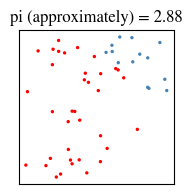

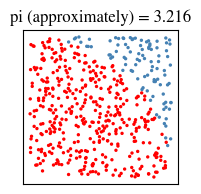

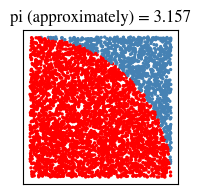

In [ ]:
r = 1

for n in 5*10**jnp.array([1,2,3]):
    approx_pi(r, n)

## Outro

### How to chose a PPL?

- functionality (e.g. availability of discrete parameters)
- open to custom distributions (and samplers)
- preformance
- well documented
- abundant library of examples
- active (and supportive) community

### Take home messages

#### 1. Advantages of Bayesian inference

- allows to use domain knowledge about the research question
- incorporate various sources of knowledge
- can answer a broad variety of question by computing desired qunatities from posterior samples
- can work with small data

#### 2. Disadvantages of Bayesian inference

- computationally involved
- even running a model in a PPL can take a lot of time
- for MCMC moethods convergence is achieved, in theory, only at infinite number of iterations

#### 3. PPLs

- modern approach to inference
- provide the iference "button"
- only the model needs to be formulated
- each PPL has its own syntaxis


## Resources

Pyro:
- https://pyro.ai/

NumPyro:
- https://num.pyro.ai/en/stable/index.html